# Evaluation of the 2018 visa data for Chile

After basic analysing in _1analysis.ipynb_, the next step in understanding the data is to find relations between several columns and maybe even build stochastic or machine learning (ML) models from the new developed insights.

## Packages

The following packages are used in the evaluation process and must therefore be imported.

In [1]:
# Import used packages
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading the data

As before in _1analysis.ipynb_, the data must once again be loaded into a data frame.

In [13]:
# Load data
input_data = "../data/data.parquet"
df = pd.read_parquet(input_data)

# Reinterpret categories
def convert_to_category(df: pd.DataFrame, keys: list[str]) -> pd.DataFrame:
  for key in keys:
    df[key] = df[key].astype('category')
  return df

df = df.convert_dtypes()
df = convert_to_category(df,
                        ['sex', 'country', 'activity',
                         'profession', 'studies', 'community', 'state',
                         'region', 'visa_reason', 'month'])
df['birthday'] = pd.to_datetime(df['birthday'])

# Delete redundant year column
del df['year']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438232 entries, 0 to 438231
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   sex          438232 non-null  category      
 1   country      438232 non-null  category      
 2   birthday     438231 non-null  datetime64[ns]
 3   activity     438232 non-null  category      
 4   profession   438232 non-null  category      
 5   studies      438232 non-null  category      
 6   community    438232 non-null  category      
 7   state        438232 non-null  category      
 8   region       438232 non-null  category      
 9   visa_reason  438232 non-null  category      
 10  month        438232 non-null  category      
 11  age          438232 non-null  Int64         
 12  imports      438232 non-null  Int64         
 13  cargo        438232 non-null  Int64         
dtypes: Int64(3), category(10), datetime64[ns](1)
memory usage: 19.7 MB


Once again, some columns can also be translated automatically, again.

In [14]:
# Translate country list
# found on https://121spanish.com/nationalities
country_df = pd.read_csv("../data/country_translations.csv", sep='\t')
del country_df['Language'], country_df['Nationality']
translation_dict = country_df.set_index('Country').to_dict()['In English']

# Some translations don't work -> we do them manually
translation_dict.update({
    'Haití':            'Haiti',
    'Líbano':           'Lebanon',
    'Nueva Zelanda':    'New Zealand',
    'Rumanía':          'Rumania',
    'Sudráfica':        'South Africa',         # Spelling mistake is actually in data
    'República De Bielorrusia': 'Belarus',
    'República De Serbia':  'Serbia',
    'República de Congo':   'Congo',
    'Otro país':        'Other Country'
})

df.country = df.country.cat.rename_categories(translation_dict)

# Translate sex
df.sex = df.sex.cat.rename_categories({'Femenino': 'Female', 'Masculino': 'Male'})

## Additional data being used

Apart from the already provided visa data, additional data is used for further insights.

### GDP PPP per capita

The GDP (Nominal Gross Domestic Product) PPP (Purchasing Power Parity) per capita is a key value to determine how wealthy an average citizen is from a certain country. Therefore, this data can be used in conjunction with the _country_ column.
The data is taken from the [Worldbank](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?most_recent_value_desc=true) (Note: the first 4 lines must be deleted, due to not matching the CSV format). Only values from 2018 are taken into account. If no data is available, the most recent data point is used (back up to 2010). The few exceptions, where no data is available at all are filled in manually by the data given by the corresponding Wikipedia page. Due to the automatic country translation, the mapping process should work automatically for most of the countries.

In [15]:
# Load GDP PPP per capita
gdp_data_path = '../data/worldbank-gdp-ppp-pcapita.csv'
gdp_df = pd.read_csv(gdp_data_path)

gdp_2018_df = gdp_df[['Country Name', '2018']].rename(columns={'Country Name': 'country'})
gdp_2018_df = gdp_2018_df.set_index('country')

no_data_countries = gdp_2018_df[gdp_2018_df['2018'].isnull()].index

for country in no_data_countries:
    for year in range(2021, 2010, -1):
        temp = float(gdp_df[gdp_df['Country Name'] == country][str(year)])
        if not math.isnan(temp):
            gdp_2018_df.at[country, '2018'] = temp
            break

gdp_2018_df[gdp_2018_df['2018'].isnull()].index

Index(['Andorra', 'American Samoa', 'Channel Islands', 'Cuba', 'Faroe Islands',
       'Gibraltar', 'Greenland', 'Guam', 'Isle of Man', 'Not classified',
       'Liechtenstein', 'St. Martin (French part)', 'Monaco',
       'Northern Mariana Islands', 'New Caledonia',
       'Korea, Dem. People's Rep.', 'French Polynesia', 'Syrian Arab Republic',
       'British Virgin Islands', 'Virgin Islands (U.S.)'],
      dtype='object', name='country')

20 countries could not be set automatically. As only those, which are also in the visa data matter, only the missing countries are filtered out manually.

In [5]:
# Finding difference (countries that are in the visa data, but not in the gdp data)
set(df.country.unique()).difference(set(gdp_2018_df[gdp_2018_df['2018'].notnull()].index))

{'Brasil',
 'Congo',
 'Cuba',
 'Czech Republic',
 'Egypt',
 'England',
 'Holand',
 'Iran',
 'Other Country',
 'Palestina',
 'Rumania',
 'Russia',
 'Slovakia',
 'South Korea',
 'Syria',
 'Taiwan',
 'Turkey',
 'Venezuela'}

Apparently some countries have different tags, too, so they must be renamed in the gdp data frame.

In [16]:
# Rename data frame countries to match visa data and populate missing data
mapping = {
    'Brazil':               'Brasil',
    'Congo, Rep.':          'Congo',    # assumption from the original República de Congo (there are 2 Congos)
    'Czechia':              'Czech Republic',
    'Egypt, Arab Rep.':     'Egypt',
    'United Kingdom':       'England',
    'Netherlands':          'Holand',
    'Iran, Islamic Rep.':   'Iran',
    'Romania':              'Rumania',
    'Russian Federation':   'Russia',
    'Slovak Republic':      'Slovakia',
    'Korea, Rep.':          'South Korea',
    'Syrian Arab Republic': 'Syria',        # NaN
    'Turkiye':              'Turkey',
    'Venezuela, RB':        'Venezuela'
}

gdp_2018_df = gdp_2018_df.rename(mapping)

# https://www.macrotrends.net/countries/CUB/cuba/gdp-per-capita (no data for PPP)
gdp_2018_df.at['Cuba', '2018']          = 8824.0
gdp_2018_df.at['Other Country', '2018'] = gdp_2018_df.loc['World']['2018']
# Wikipedia
gdp_2018_df.at['Palestina', '2018']     = 3199.0
gdp_2018_df.at['Syria', '2018']         = 2900.0
gdp_2018_df.at['Taiwan', '2018']        = 35513.0

country_wealth = gdp_2018_df.loc[df.country]['2018']

gdp_2018_df

,2018
country,
Aruba,40143.000266
Africa Eastern and Southern,3761.035160
Afghanistan,2082.392197
Africa Western and Central,4231.321093
Angola,7148.933253
...,...
Zambia,3605.676095
Zimbabwe,2556.793484
Other Country,17081.437856


## Last Setups

Before plotting the data and trying to find meaningful relations, some last settings are made to the different packages to make them more suited to this use case.

In [140]:
# Configure Matplolib
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 300

## Further analysed relational data

For this analysis 4 presumptions are made, which are then checked if they are backed up by the visa data:
 1. The wealthier the country of origin, the more cargo and the more imports are made
 2. People with higher education usually come from wealthier countries
 3. The seasonality for the visa applications for students especially is quite high (twice a year), due to the beginning of the semester
 4. The biological gender distribution differs between different _visa reasons_, _activities_, and _regions_, with students having an (almost) equal sex distribution

With the insights gained in the analysis of those 4 presumptions, final assumptions with concrete numbers are made.

### Wealthier country of origin means more cargo and imports

To check those assumption, all 3 variables are plotted into a scatter plot. As the connection between imports and cargo has to be demonstrated first, the cargo and the imports are plotted on the x- and y-axis, respectively. The hue then indicates how rich a country is.

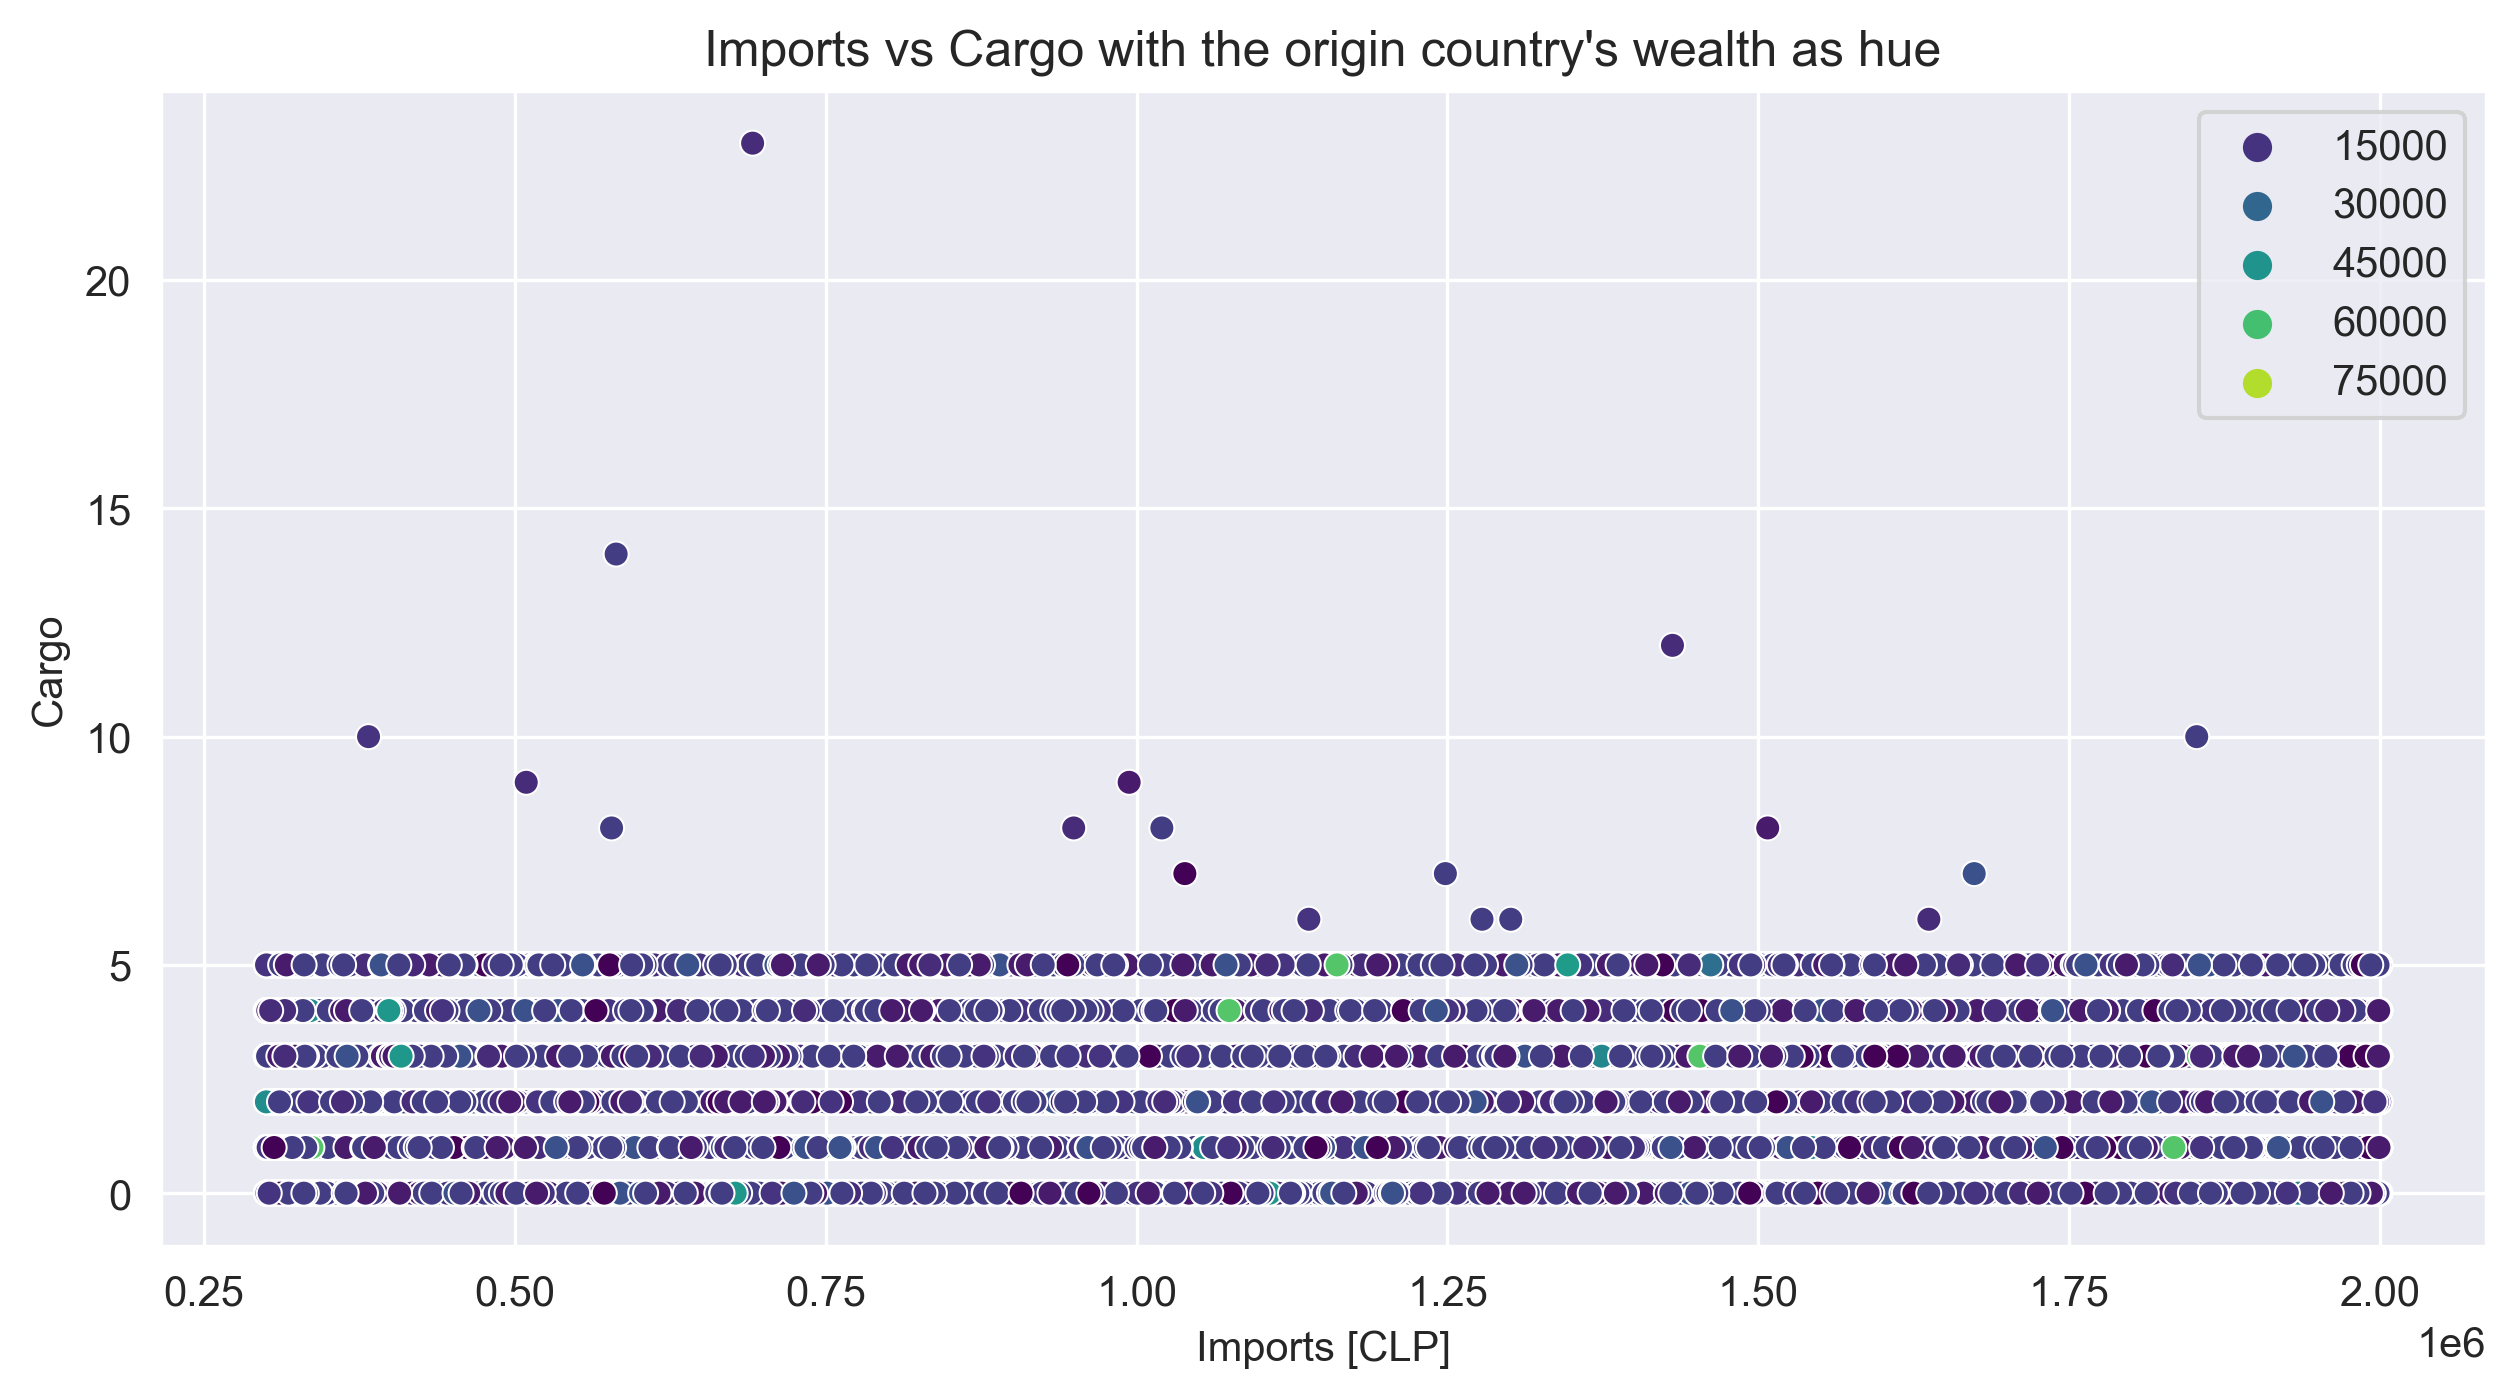

In [86]:
sns.scatterplot(x=df['imports'].to_numpy(),
                y=df['cargo'].to_numpy(),
                hue=country_wealth.to_numpy(),
                palette=sns.color_palette("viridis", as_cmap=True))
plt.xlabel("Imports [CLP]")
plt.ylabel("Cargo")
plt.xticks(rotation=0)
plt.title("Imports vs Cargo with the origin country's wealth as hue")
plt.show()

This plot does not show a distribution that is expected if that presumption was true. Consequently, the Pearson R factor is checked. If the value is $\ge 0.5$ it is assumed to be valid.

In [9]:
# Calculate covariance and Pearson's r coefficient for imports & cargo, imports & country wealth, country wealth & cargo
ic_r = stats.pearsonr(df.imports, df.cargo)
iw_r = stats.pearsonr(df.imports, country_wealth)
cw_r = stats.pearsonr(df.cargo, country_wealth)

def print_pearson_r(pearson_r, label):
    print(f"Pearson for {label}:".ljust(50), pearson_r.statistic)

print_pearson_r(ic_r, "imports & cargo")
print_pearson_r(iw_r, "imports & country wealth")
print_pearson_r(cw_r, "country wealth & cargo")

Pearson for imports & cargo:                       -0.0012481938225874843
Pearson for imports & country wealth:              9.708488790316413e-05
Pearson for country wealth & cargo:                -0.001745403975786717


Obviously, the first presumption is not backed by the data and therefore probably not true. The data is only marginally correlated and in 2 instances even negatively correlated, which means for higher imports the cargo is reduced and for wealthier countries of origin less cargo is imported.

### People with higher education usually come from wealthier countries

As the education level is a categorical value, it is more difficult to check for truthy. Therefore, this data first needs to be converted to a numerical value.
This is done by giving each educational level a score (higher education means higher score). Additionally, all entries, where the educational level is unknown get filtered out. This study score follows the normal time needed to get to this educational level. Only adults of age 21 and older are considered, as children don't have the chance to higher education. Lastly, this score is scaled by an age considering factor calculated by $s = \frac{28}{age}$ for $s > 1$. This tries to take into account the potential that the youth has to complete a higher career. Usually this happens up to the age of 28.
Before plotting the data like before, the Pearson R coefficient is calculated first. Only if it shows a positive correlation, a plot is also created.

In [18]:
# Create educational score
sub_df = df[(df.age > 20) & (df.studies != 'No Informa')]
age_factor = sub_df.age.apply(lambda age: 28 / age if age < 28 else 1)

career_mapping = {
    'No Informa': -1,
    'Ninguno': 0,
    'Prebásico': 1,         # in reality not really different to no education at all
    'Básico': 6,
    'Medio': 12,
    'Técnico': 16.5,
    'Universitario': 17
}

career_scores = (sub_df.studies.apply(lambda x: career_mapping[x]).astype('float') * age_factor).reset_index(drop=True)

cw_r = stats.pearsonr(career_scores, gdp_2018_df.loc[sub_df.country]['2018'])
print_pearson_r(cw_r, "education score & country wealth")

Pearson for education score & country wealth:      0.4085079971915677


This shows that there is definitely a weak correlation, indicating the thesis is at least somewhat true. By removing the weight bias from the data (countries with more data points should not get more attention), the correlation should be stronger.

In [90]:
# Plot the education score against the country wealth
edu_df = career_scores.to_frame('score')
edu_df['wealth'] = gdp_2018_df.loc[sub_df.country]['2018'].reset_index(drop=True)

avgs = edu_df.groupby(['wealth']).mean().reset_index()
print_pearson_r(stats.pearsonr(avgs.score, avgs.wealth), "normalized education score & country wealth")

Pearson for normalized education score & country wealth: 0.5280790483473328


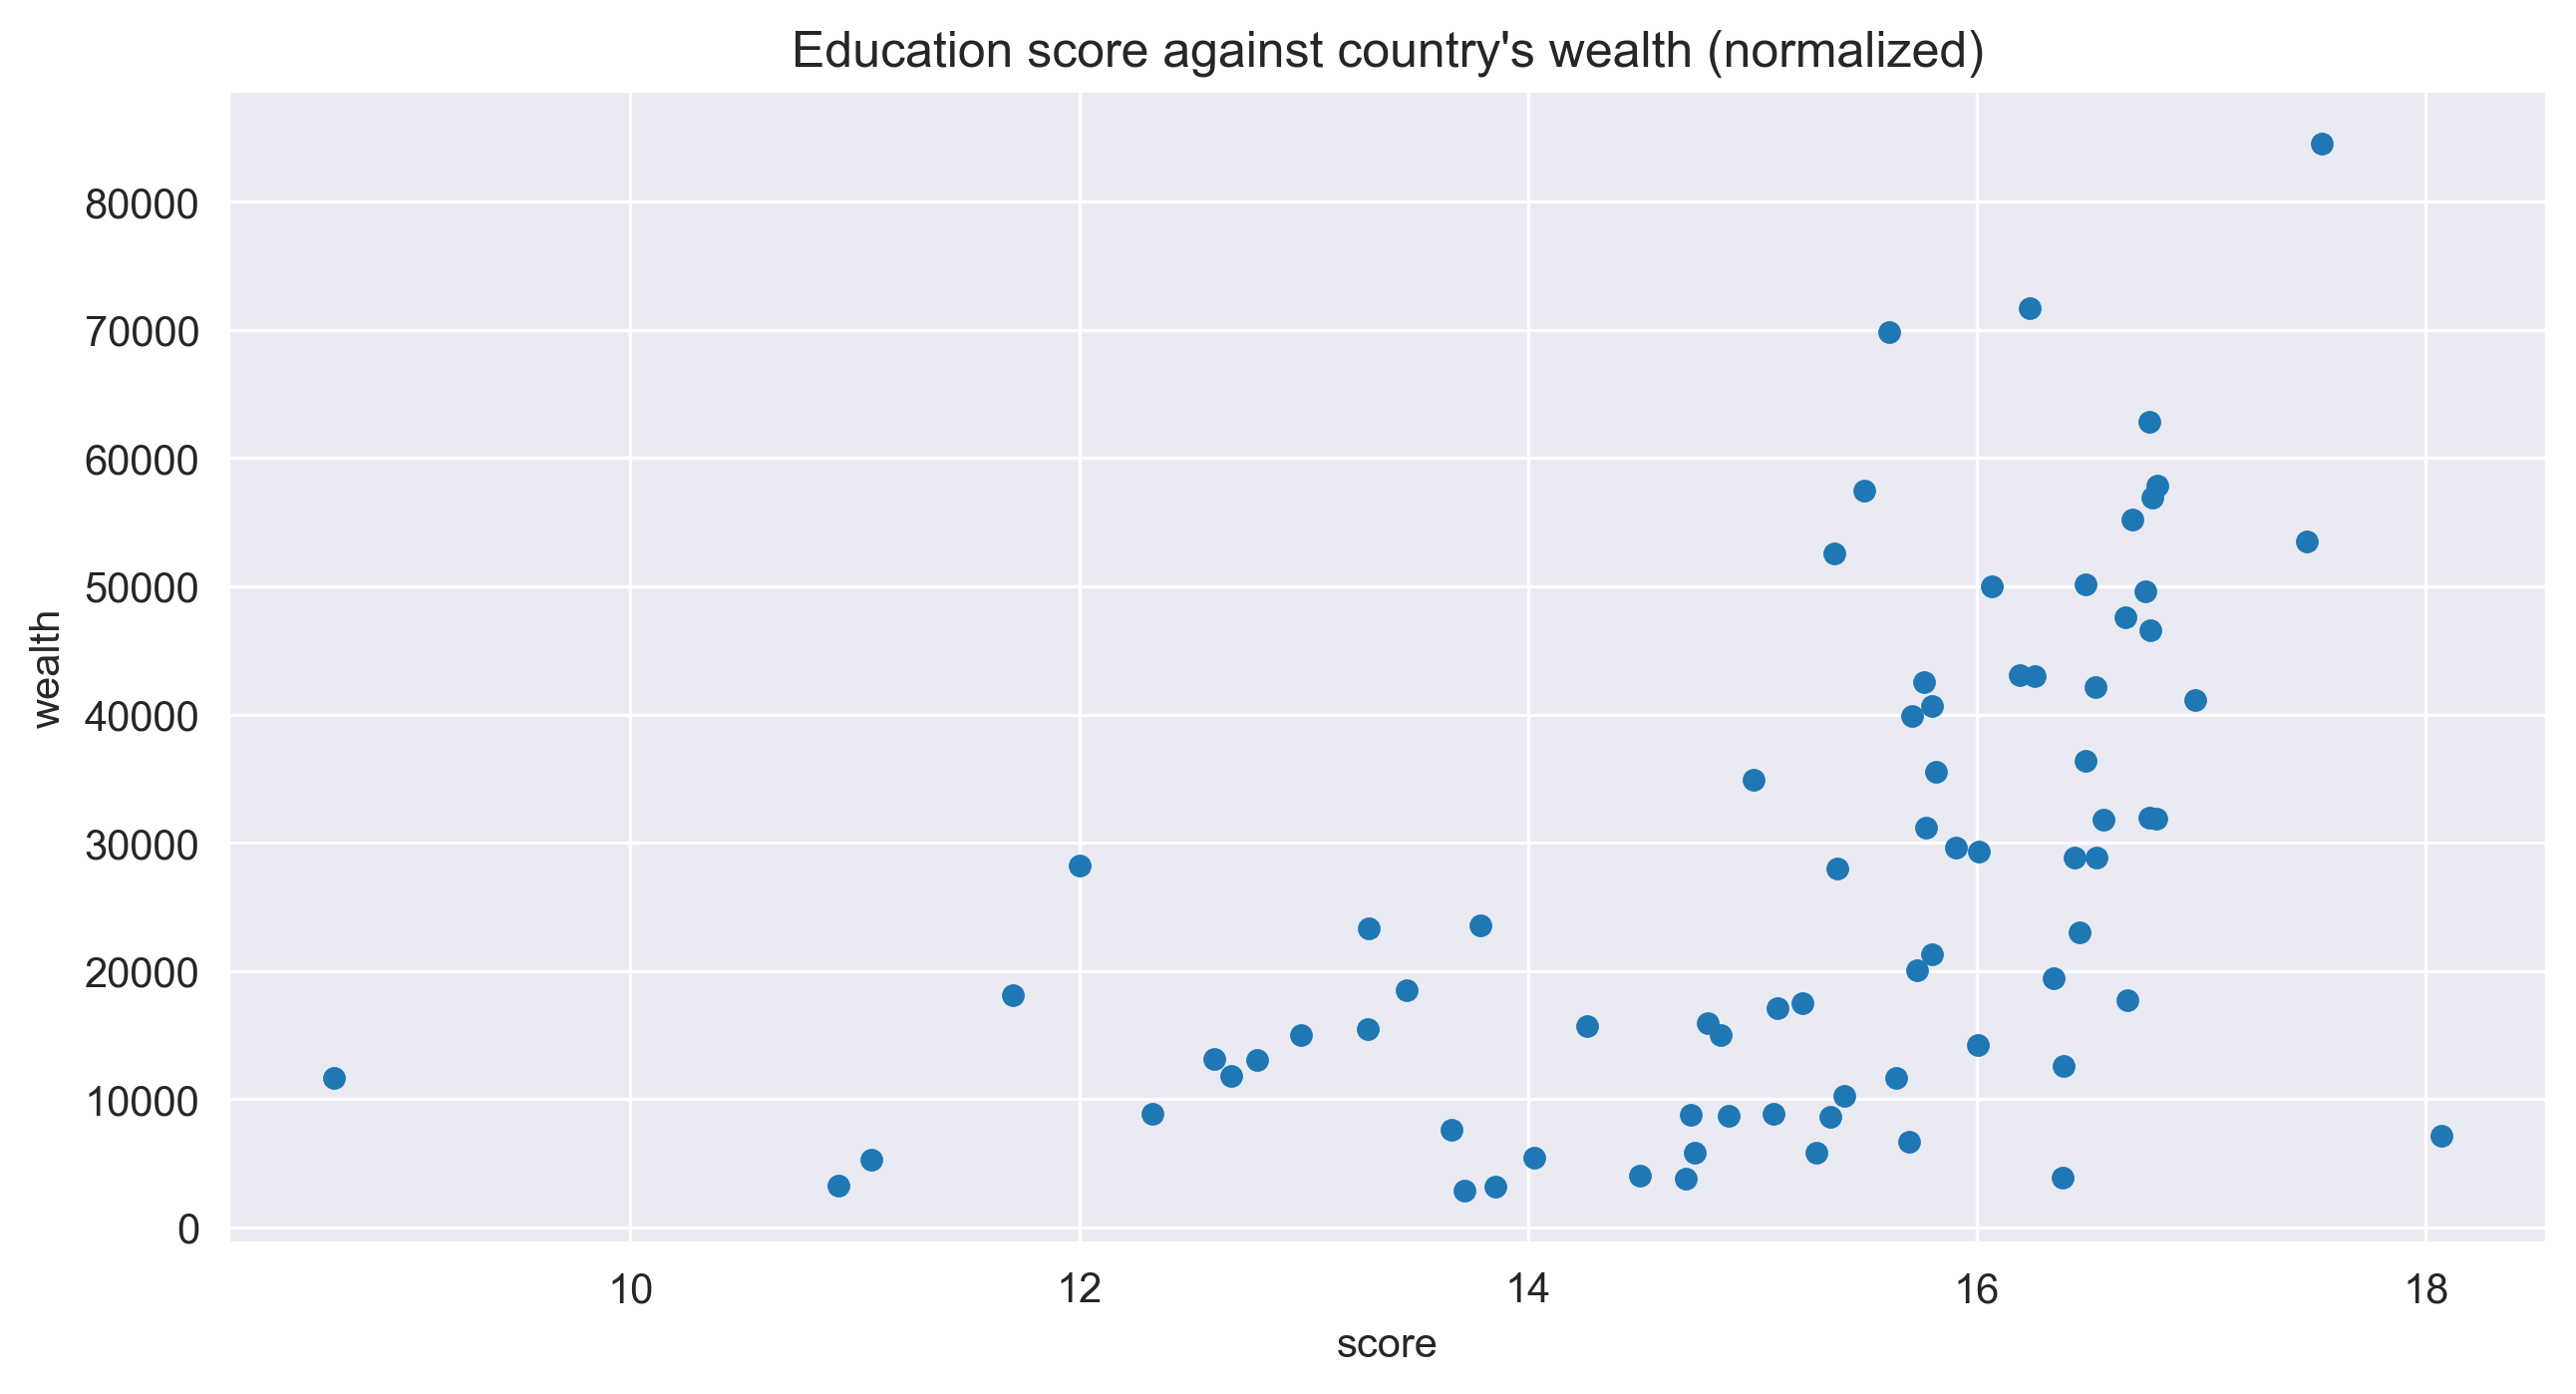

In [91]:
# Plot of the mean education score for an origin country's wealth
avgs.plot.scatter(x='score', y='wealth')
plt.title("Education score against country's wealth (normalized)")
plt.xticks(rotation=0)
plt.show()

The correlation score of 0.53 and the graph definitely reveal a correlation and proof the thesis to be true. Regarding the outliers, it might help to set a minimum level of entries of at least 25 immigrants from a certain country.

In [92]:
# Plot the education score against the country wealth
edu_df = career_scores.to_frame('score')
edu_df['wealth'] = gdp_2018_df.loc[sub_df.country]['2018'].reset_index(drop=True)

edu_df = edu_df[edu_df.wealth.isin(edu_df.wealth.unique()[edu_df.groupby('wealth').size() >= 25])]

avgs = edu_df.groupby(['wealth']).mean().reset_index()
print_pearson_r(stats.pearsonr(avgs.score, avgs.wealth), 'filtered norm. edu. score & wealth')

Pearson for filtered norm. edu. score & wealth:    0.5556108493818555


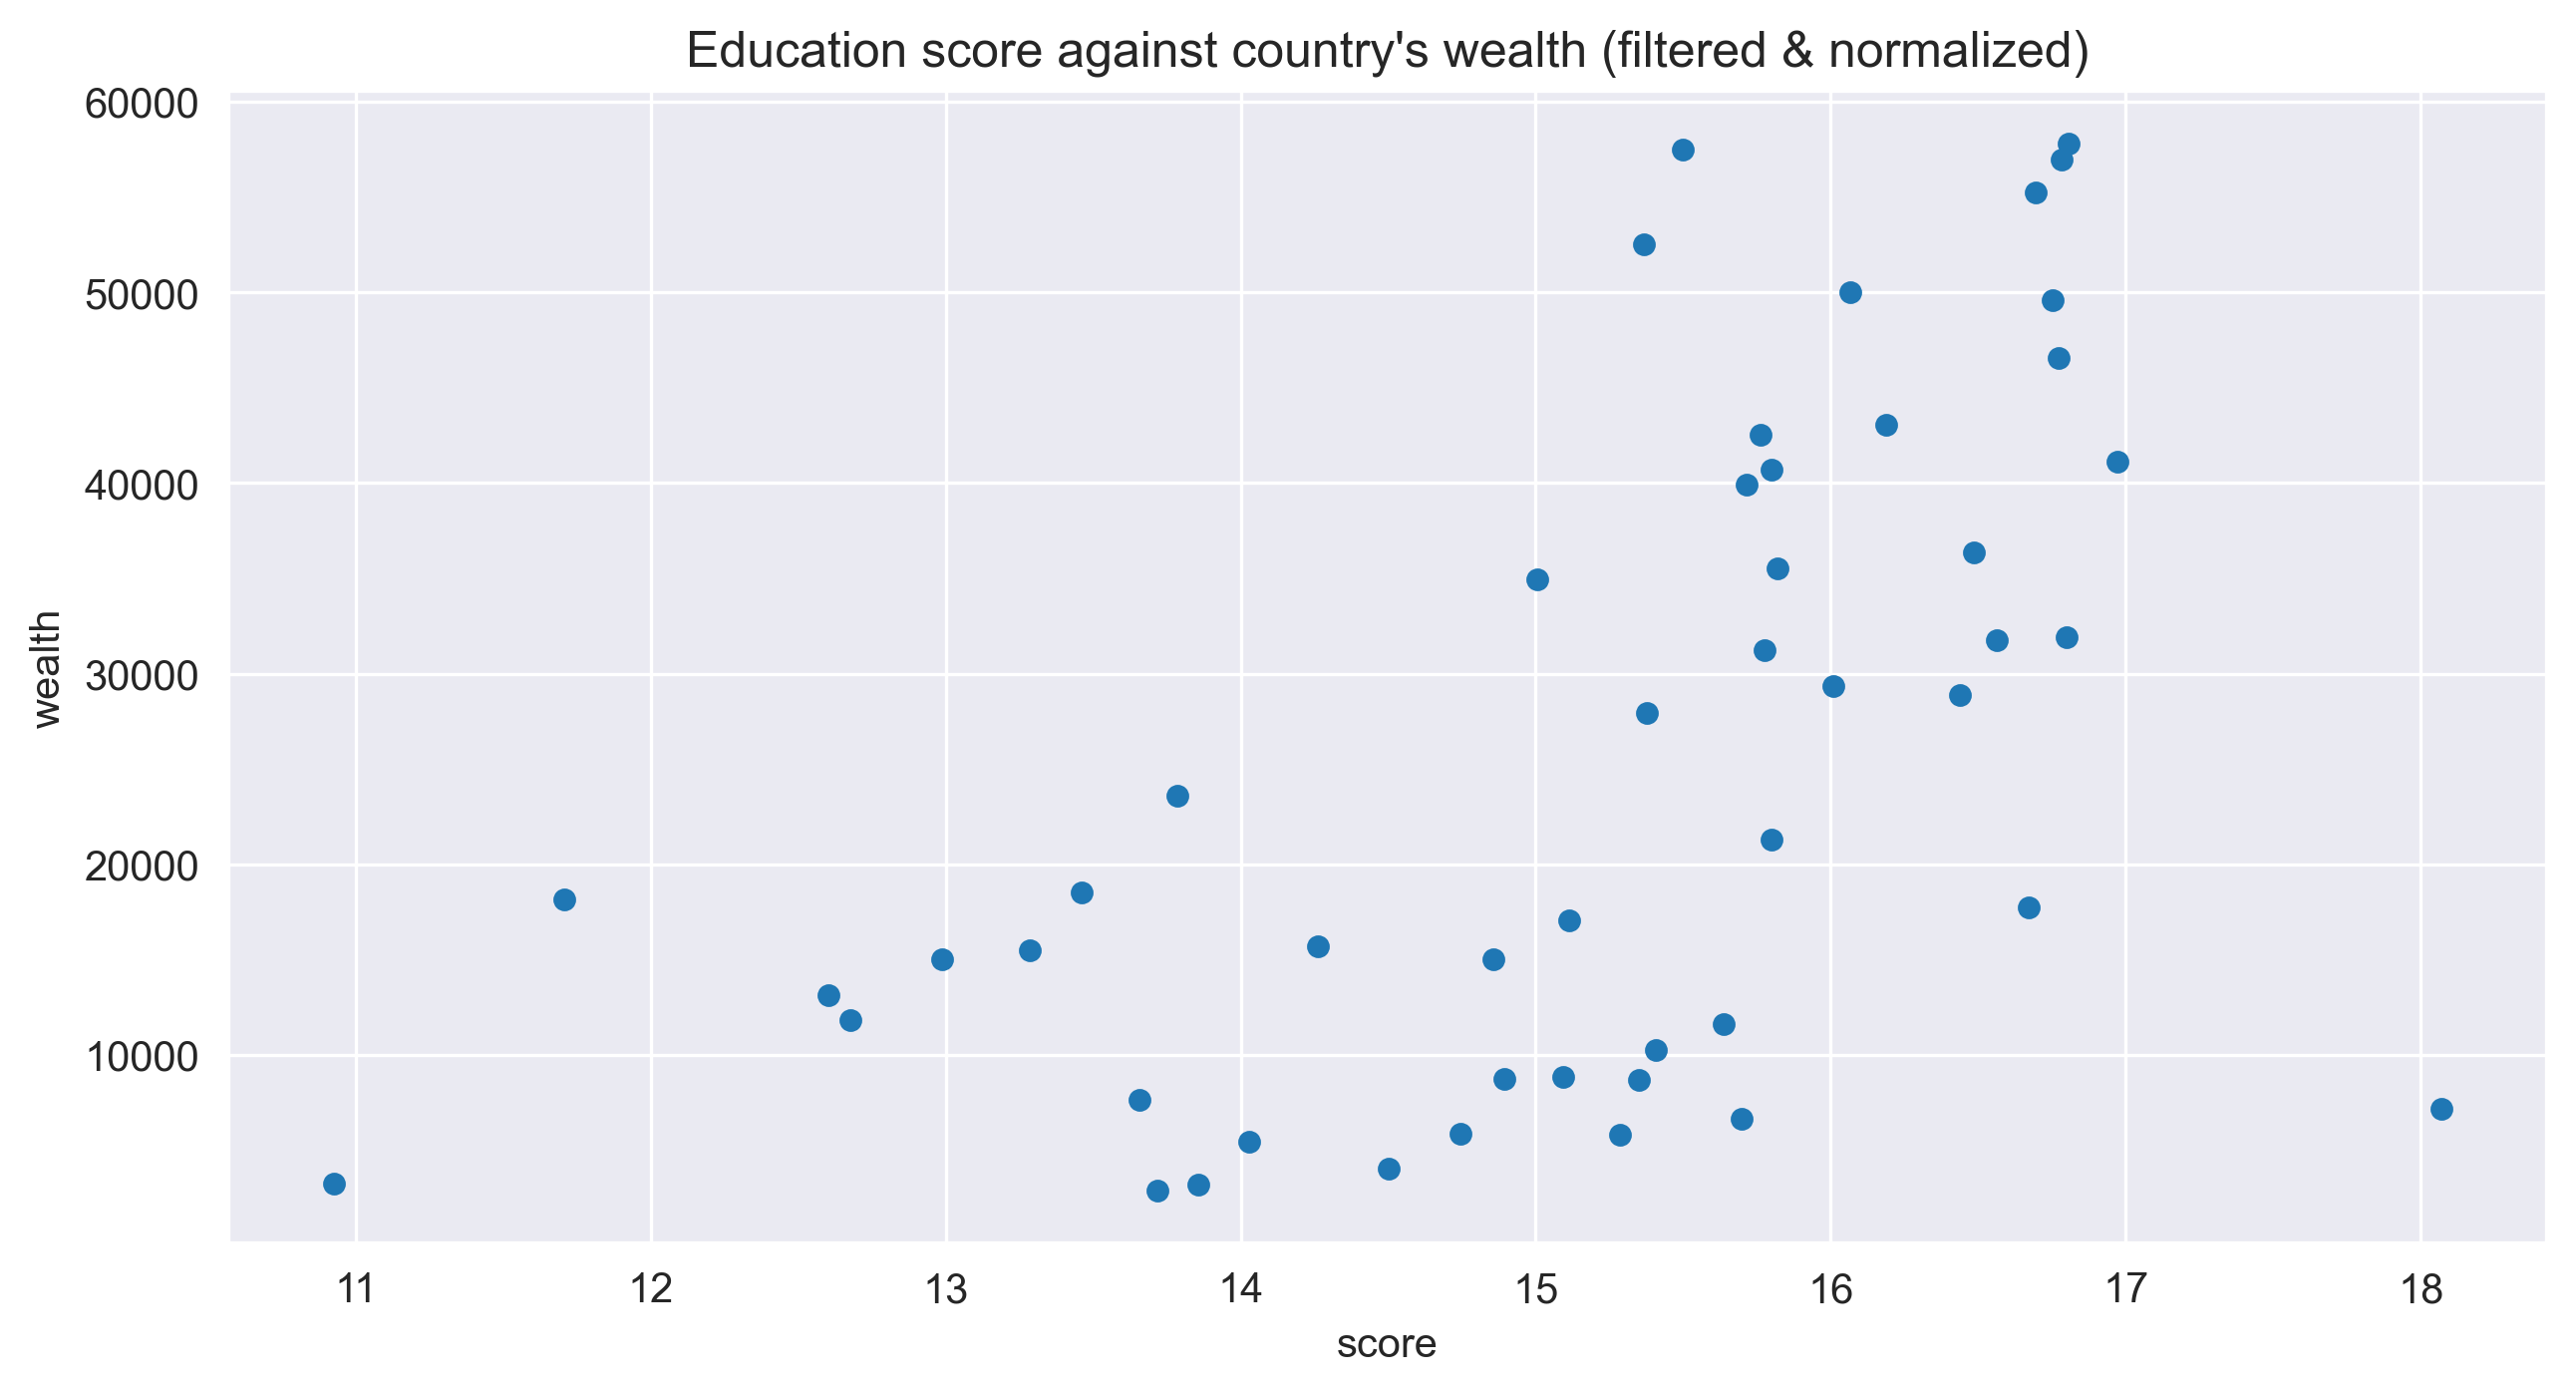

In [93]:
# Plot of the mean education score for an origin country's wealth
avgs.plot.scatter(x='score', y='wealth')
plt.title("Education score against country's wealth (filtered & normalized)")
plt.xticks(rotation=0)
plt.show()

This again shows that the relation definitely exists, it might just not be linear. As shown by the following examples between Germany and Haiti.

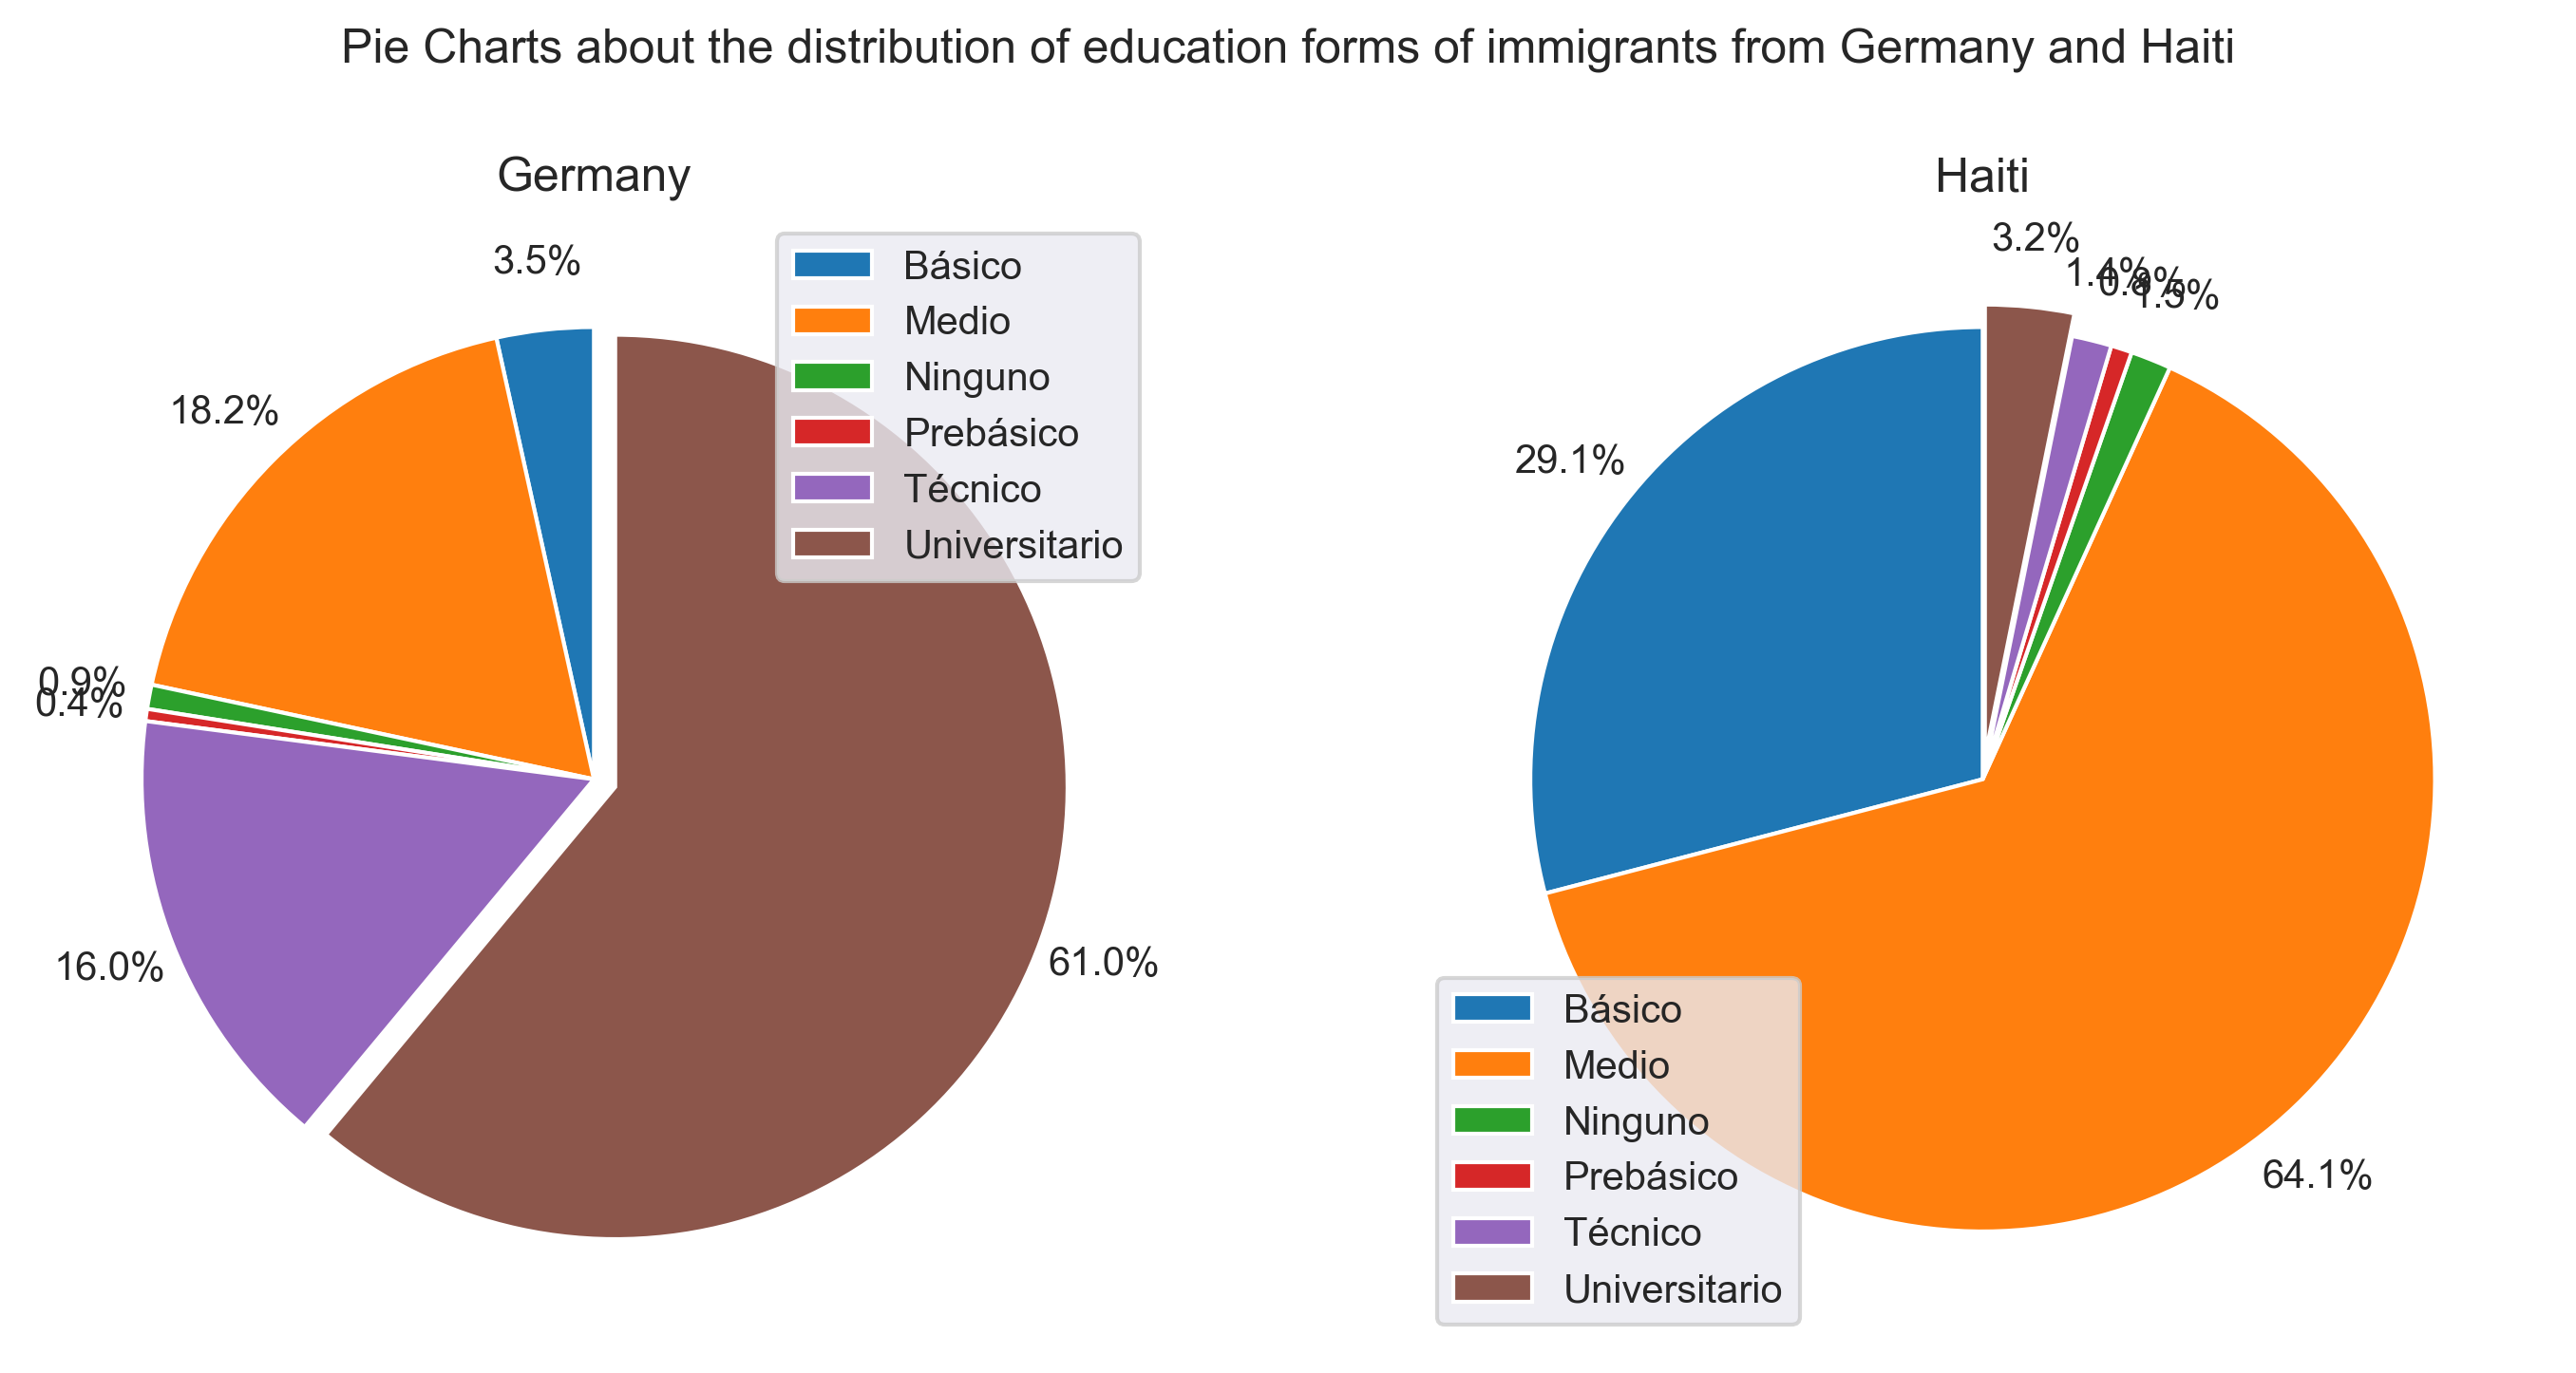

In [344]:
# Plot education levels for Haiti and Germany
edu_comparison = df[df.country.isin(['Germany', 'Haiti'])].groupby(['country', 'studies']).size()[['Germany', 'Haiti']]
edu_comparison = edu_comparison.reset_index().rename(columns={0: 'counts'})
edu_comparison.drop(edu_comparison[edu_comparison['studies'] == 'No Informa'].index, inplace=True)
sums = edu_comparison[['country', 'counts']].groupby('country').sum().loc[edu_comparison.country.unique()]

fig, axs = plt.subplots(1, len(sums))

for i, country in enumerate(sums.index):
    edu_comparison.loc[edu_comparison[edu_comparison.country == country].index, 'counts'] /= sums.loc[country][0]
    edu_comparison[edu_comparison.country == country]['counts'].plot.pie(startangle=90,
                                                                         explode=(0, 0, 0, 0, 0, 0.05),
                                                                         ax=axs[i],
                                                                         autopct='%1.1f%%',
                                                                         pctdistance=1.15,
                                                                         labels=None)
    axs[i].legend(loc='best', labels=edu_comparison[edu_comparison.country == country]['studies'])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(country)

fig.suptitle("Pie Charts about the distribution of education forms of immigrants from Germany and Haiti")
fig.tight_layout(pad=2.0)

plt.show()

The pie chart shows that $61.0\%$ of the German immigrants are students (a wealthy country) compared to $3.2\%$ (a relatively poor country).

### Visas issued to students have 2 peaks each year

Checking this presumption is done by a graphic analysis. Therefore, the month of the issued visas of students are plotted against the rest of the issued visa. Due to the big differences in counts between visa for students and those for the other reasons, both counts get scaled to be on similar heights.

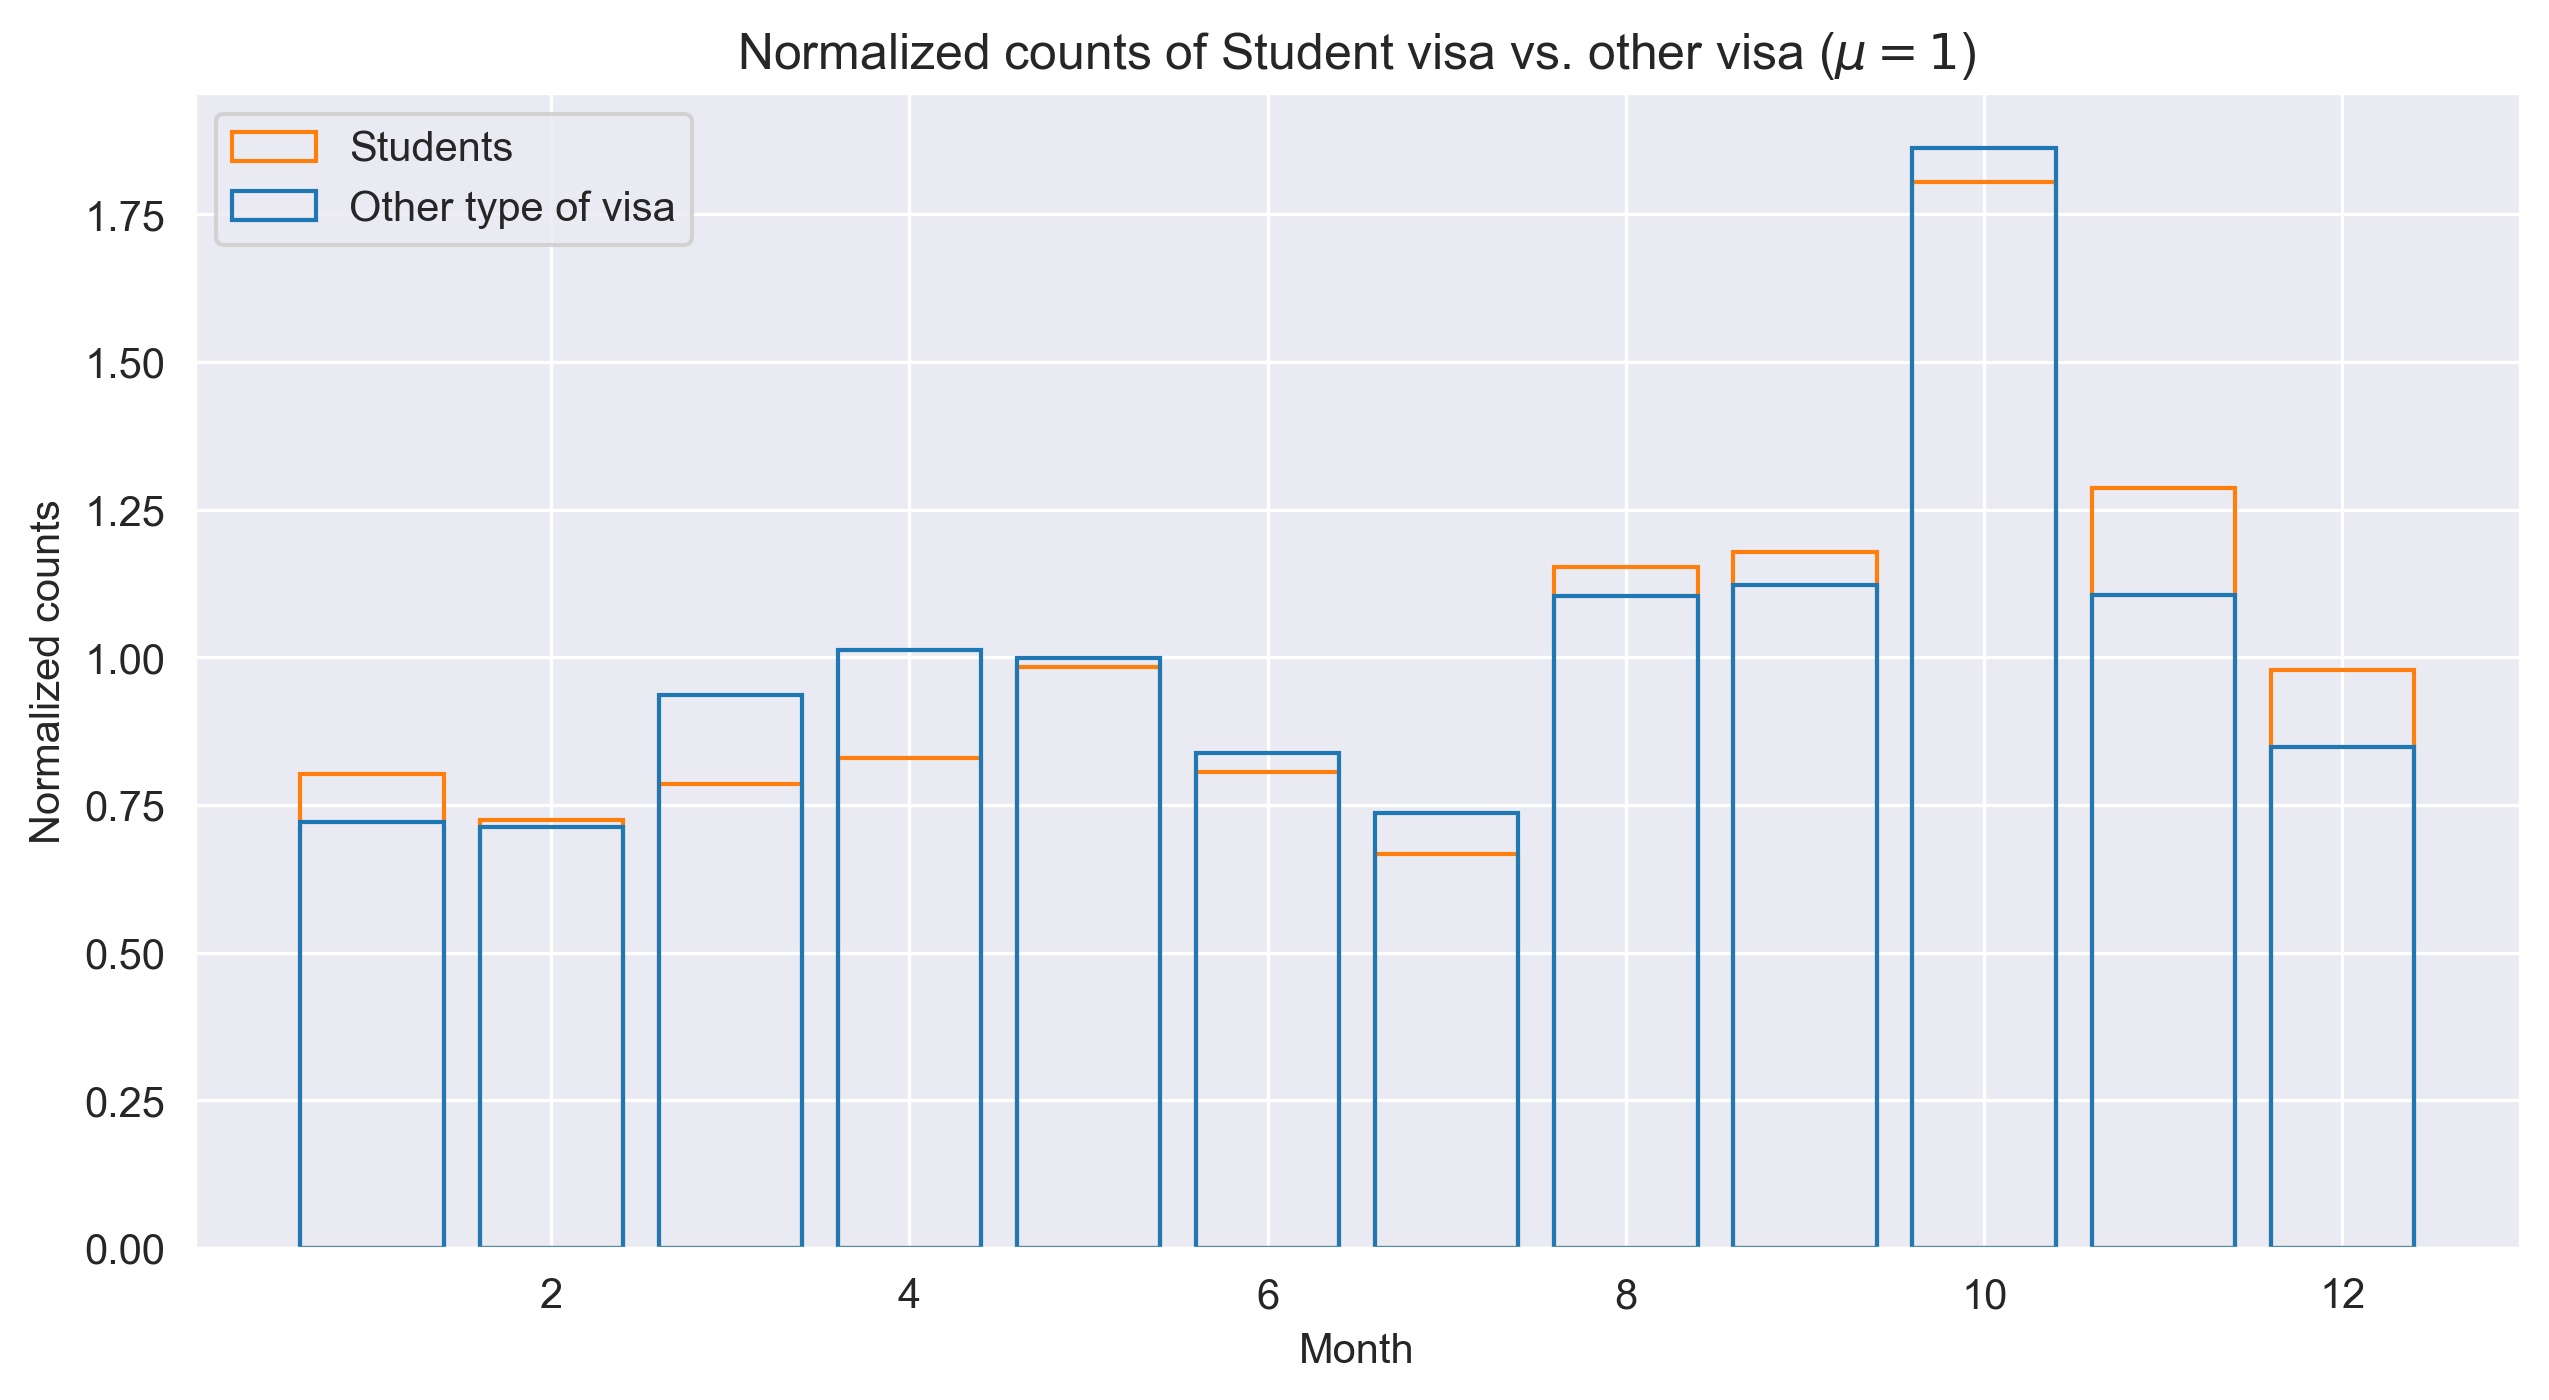

In [382]:
# Plot student visa months against rest of visa
edu_comparison = df[df['activity'] != 'No Informa'][['activity', 'month']]
students = edu_comparison[edu_comparison['activity'] == 'Estudiante'].groupby('month').size()
rest = edu_comparison[edu_comparison['activity'] != 'Estudiante'].groupby('month').size()

# scale
students = students / students.mean()
rest = rest / rest.mean()

plt.bar(x=students.index, height=students, edgecolor='tab:orange', color='#00000000', label='Students')
plt.bar(x=rest.index, height=rest, edgecolor='tab:blue', color='#00000000', label='Other type of visa')

plt.title("Normalized counts of Student visa vs. other visa ($\mu = 1$)")
plt.xlabel("Month")
plt.ylabel("Normalized counts")
plt.xticks(rotation=0)
plt.legend(loc='best')

plt.show()

While all visa seem to follow a seasonal pattern, the student visa pattern differs from the pattern of the others. The month October is an outlier for all visa types which is concluded by the fact that it does not seem to either of the visa types.
While all visa usually have a peak every six month starting in April, student visa are usually issued a month later - almost 3 month before the beginning of the new semester (October is expected to usually be a lot lower). The demand for Winter Semesters (starting in February) is a lot higher than the one for the Summer semester. The form of the distribution of a typical visa usually follows some kind of bell curve, the Student visa do not. They have an asymmetric distribution about their semestrial peak, sharing a minimum with all the other visa.

It can be concluded that a typical student coming to Chile starts for the Winter semester and applies for his visa 3 month prior. To validate this thesis additional data (i.e. visa data for the recent years) is needed.

### Sex distribution for students is more equal than for the rest of the visa

As prior, a graphical analysis helps to analyse the presumption. As the biological gender is a binary data field, different pie charts are used for one dimensional queries, and bar charts with adjacent binary pairs for each dimension for multidimensional ones.

In [ ]:
# Analysis of sex differences between the normal Visa applications and those for
#  - students
#  - high education (Medio, Técnico, or Universitario)
#  - those, living now in different regions
#  - country of origin

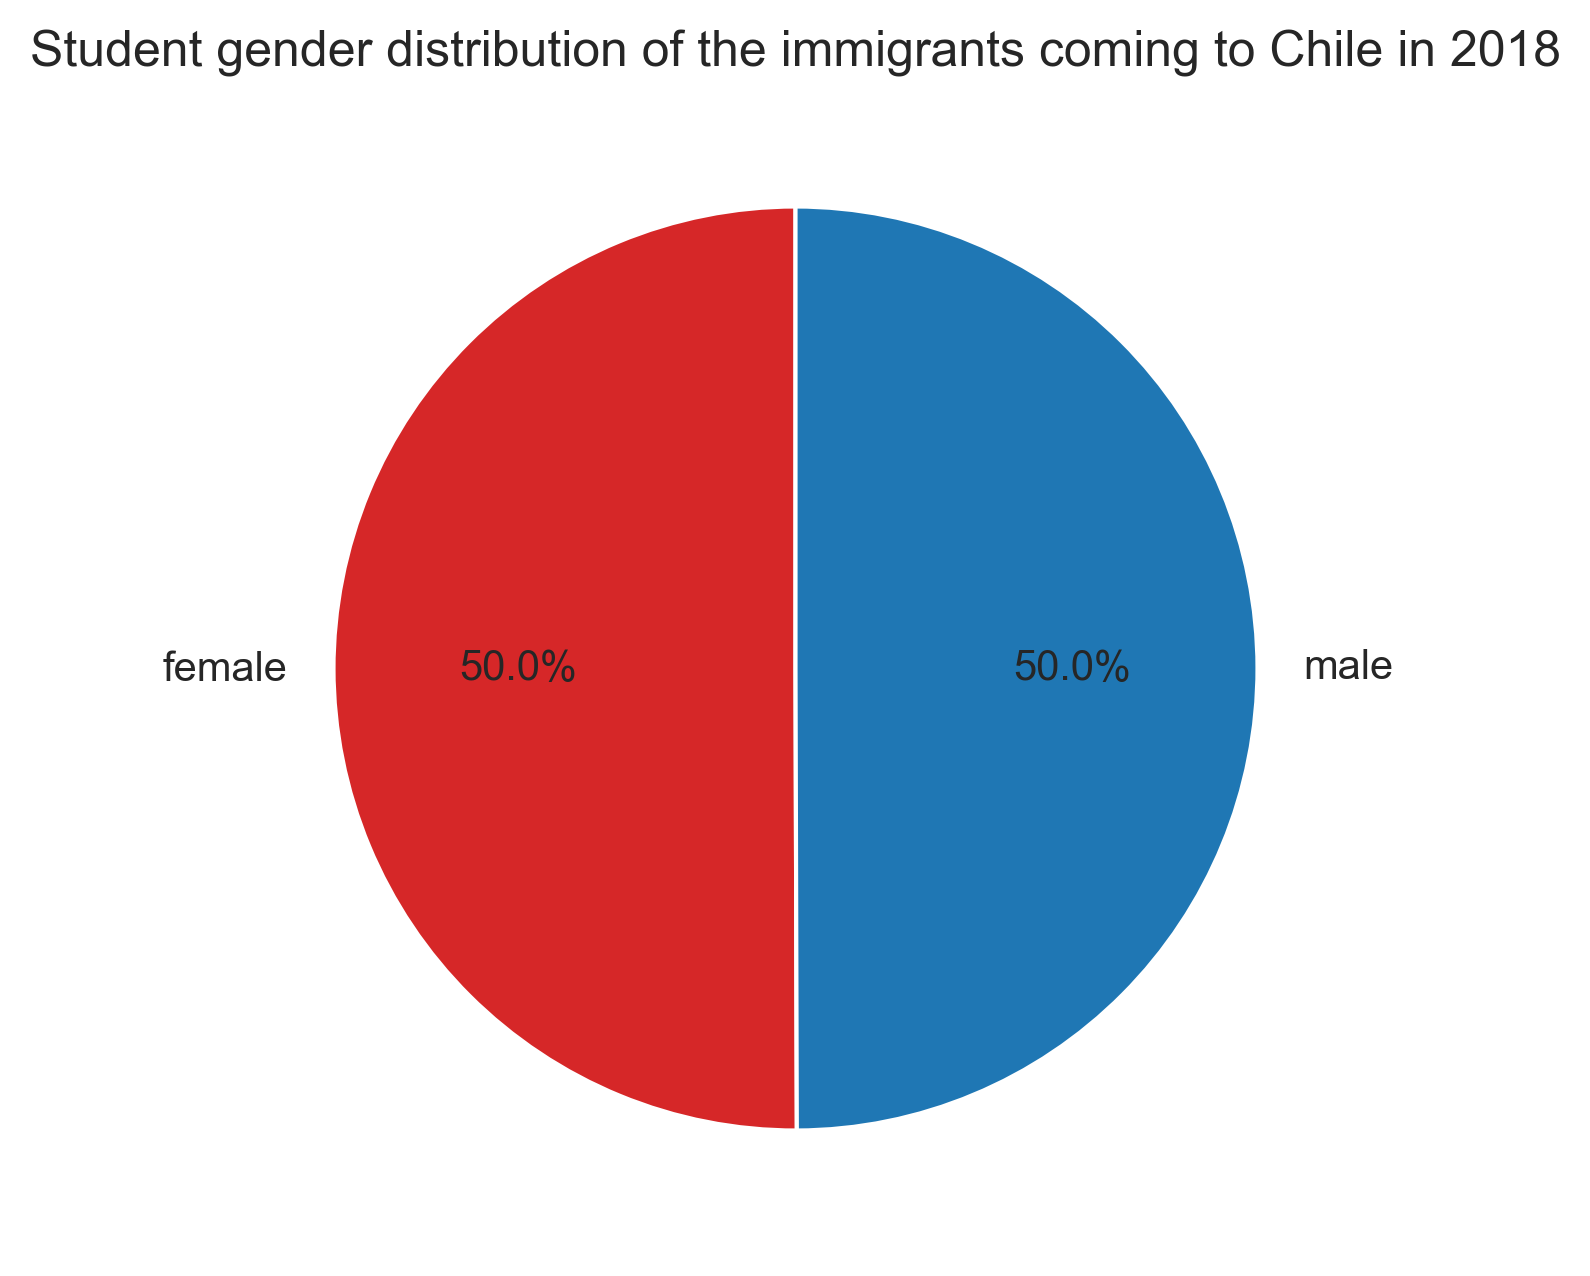

In [397]:
# Create Pie Chart for Gender analysis for students
students = df[df['activity'] == 'Estudiante'].sex
plt.pie(x=students.value_counts(),
        startangle=90,
        autopct='%1.1f%%',
        labels=['female', 'male'],
        colors=['tab:red', 'tab:blue'])
plt.title("Student gender distribution of the immigrants coming to Chile in 2018")
plt.show()

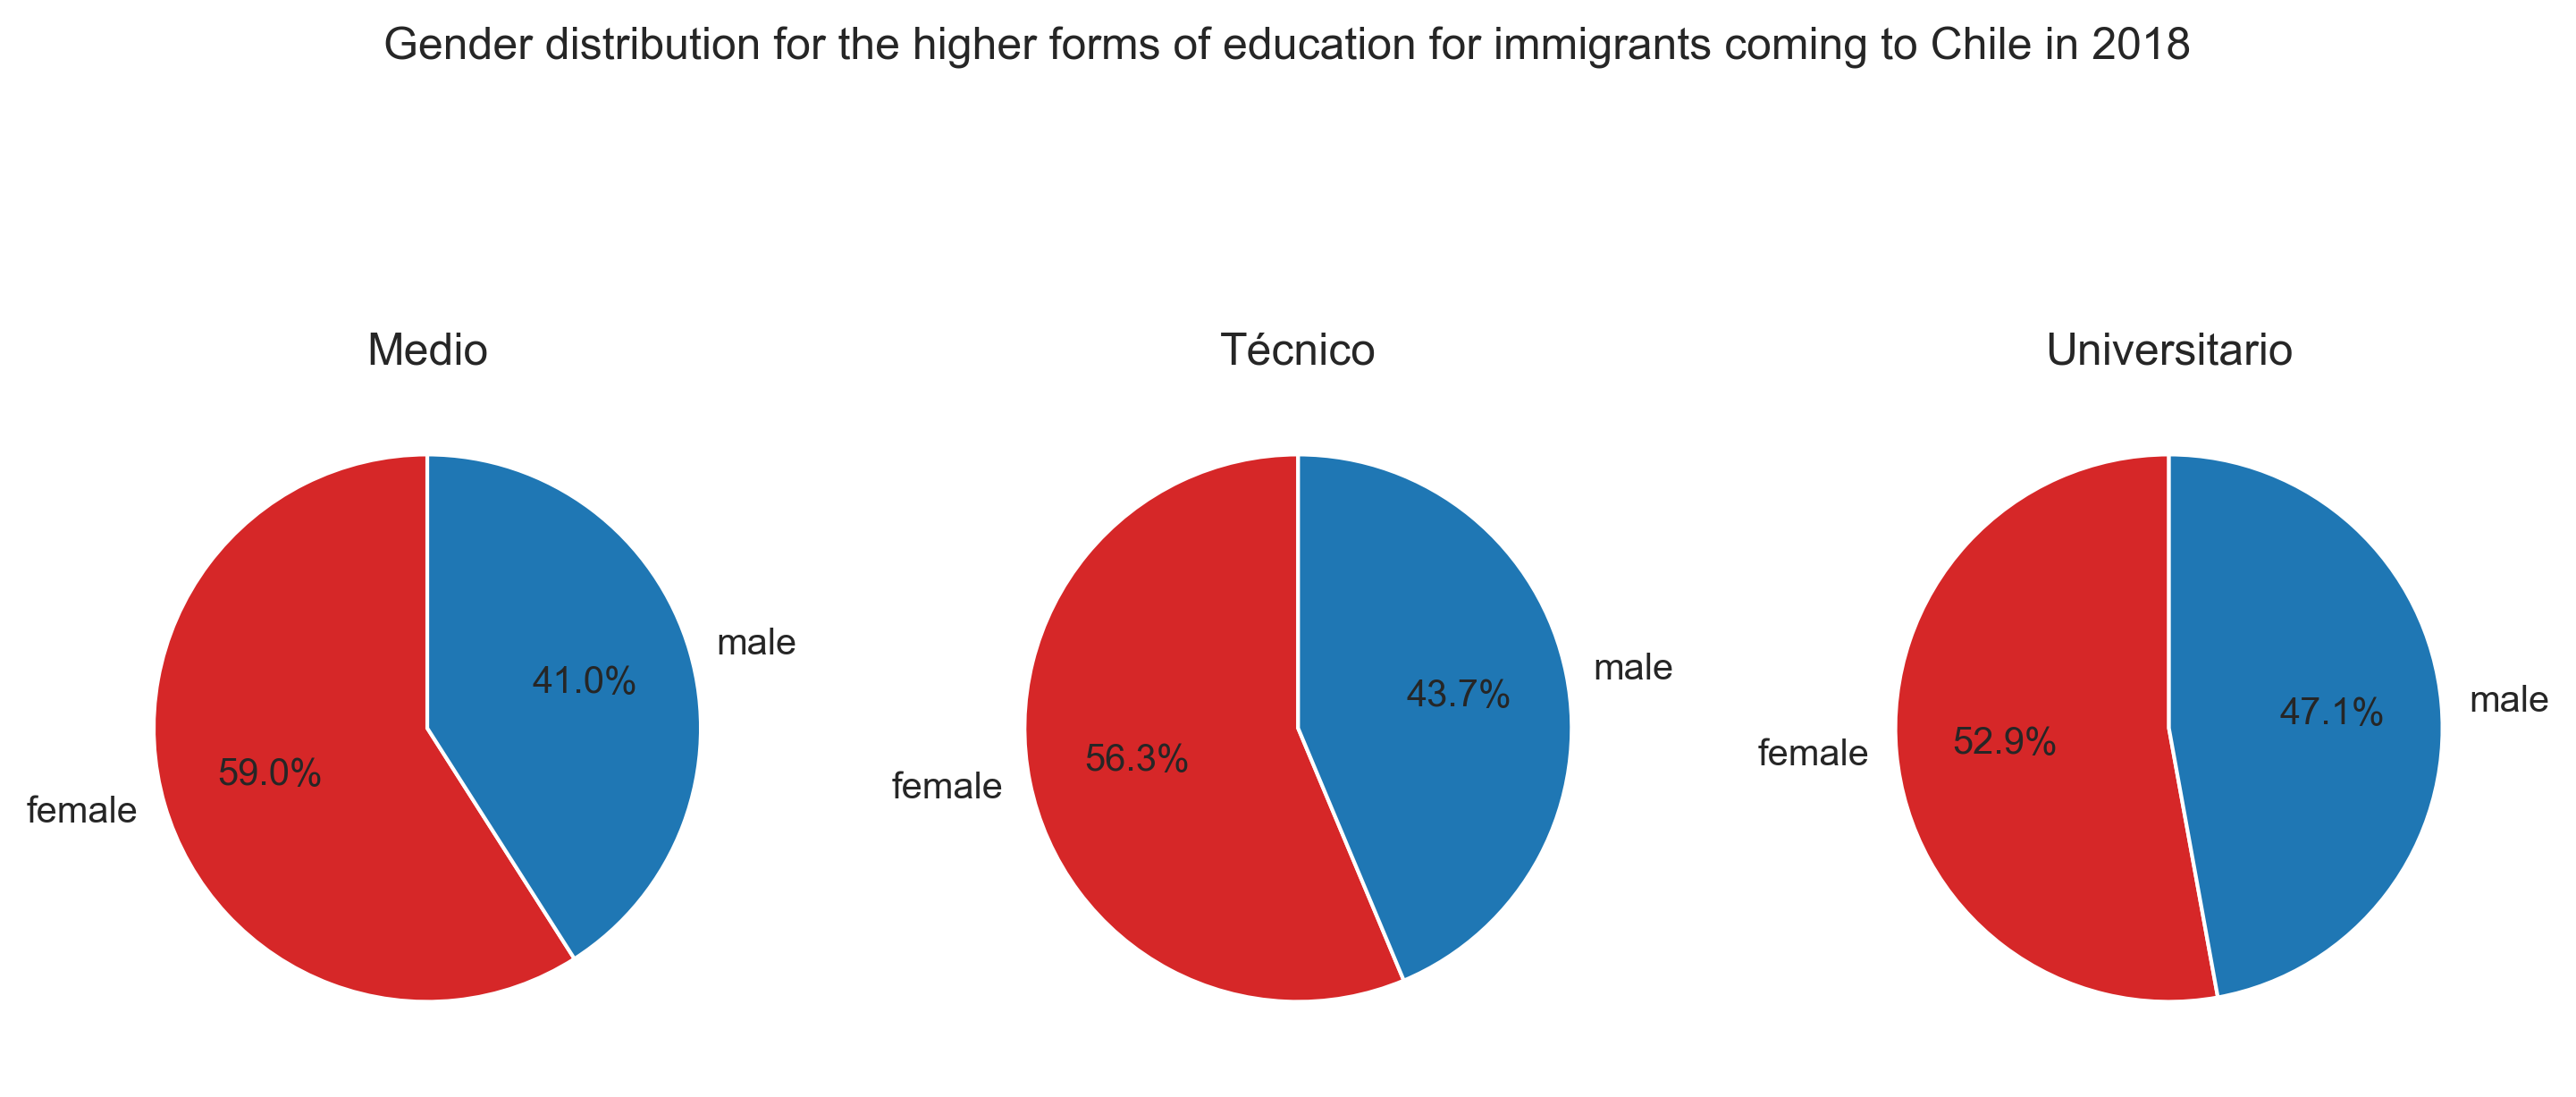

In [412]:
# Create Pie Chart for Gender analysis for the higher forms of education (Medio, Técnico, or Universitario)
forms = ['Medio', 'Técnico', 'Universitario']
medios = df[df['studies'] == 'Medio'].sex
tecnicos = df[df['studies'] == 'Técnico'].sex
universitarios = df[df['studies'] == 'Universitario'].sex

fig, axs = plt.subplots(1, 3)

for i, v in enumerate([medios, tecnicos, universitarios]):
    axs[i].pie(x=v.value_counts(),
               startangle=90,
               autopct='%1.1f%%',
               labels=['female', 'male'],
               colors=['tab:red', 'tab:blue'])

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(forms[i])

fig.suptitle("Gender distribution for the higher forms of education for immigrants coming to Chile in 2018")
fig.tight_layout(pad=2.0)

plt.show()

At this point, it can be concluded that the large majority of the immigrants are rather unskilled (or have an undefined educational level). Most of the skilled immigrants are female - students are almost perfectly divided into men and women ($50.0\%$ - $50.0\%$).

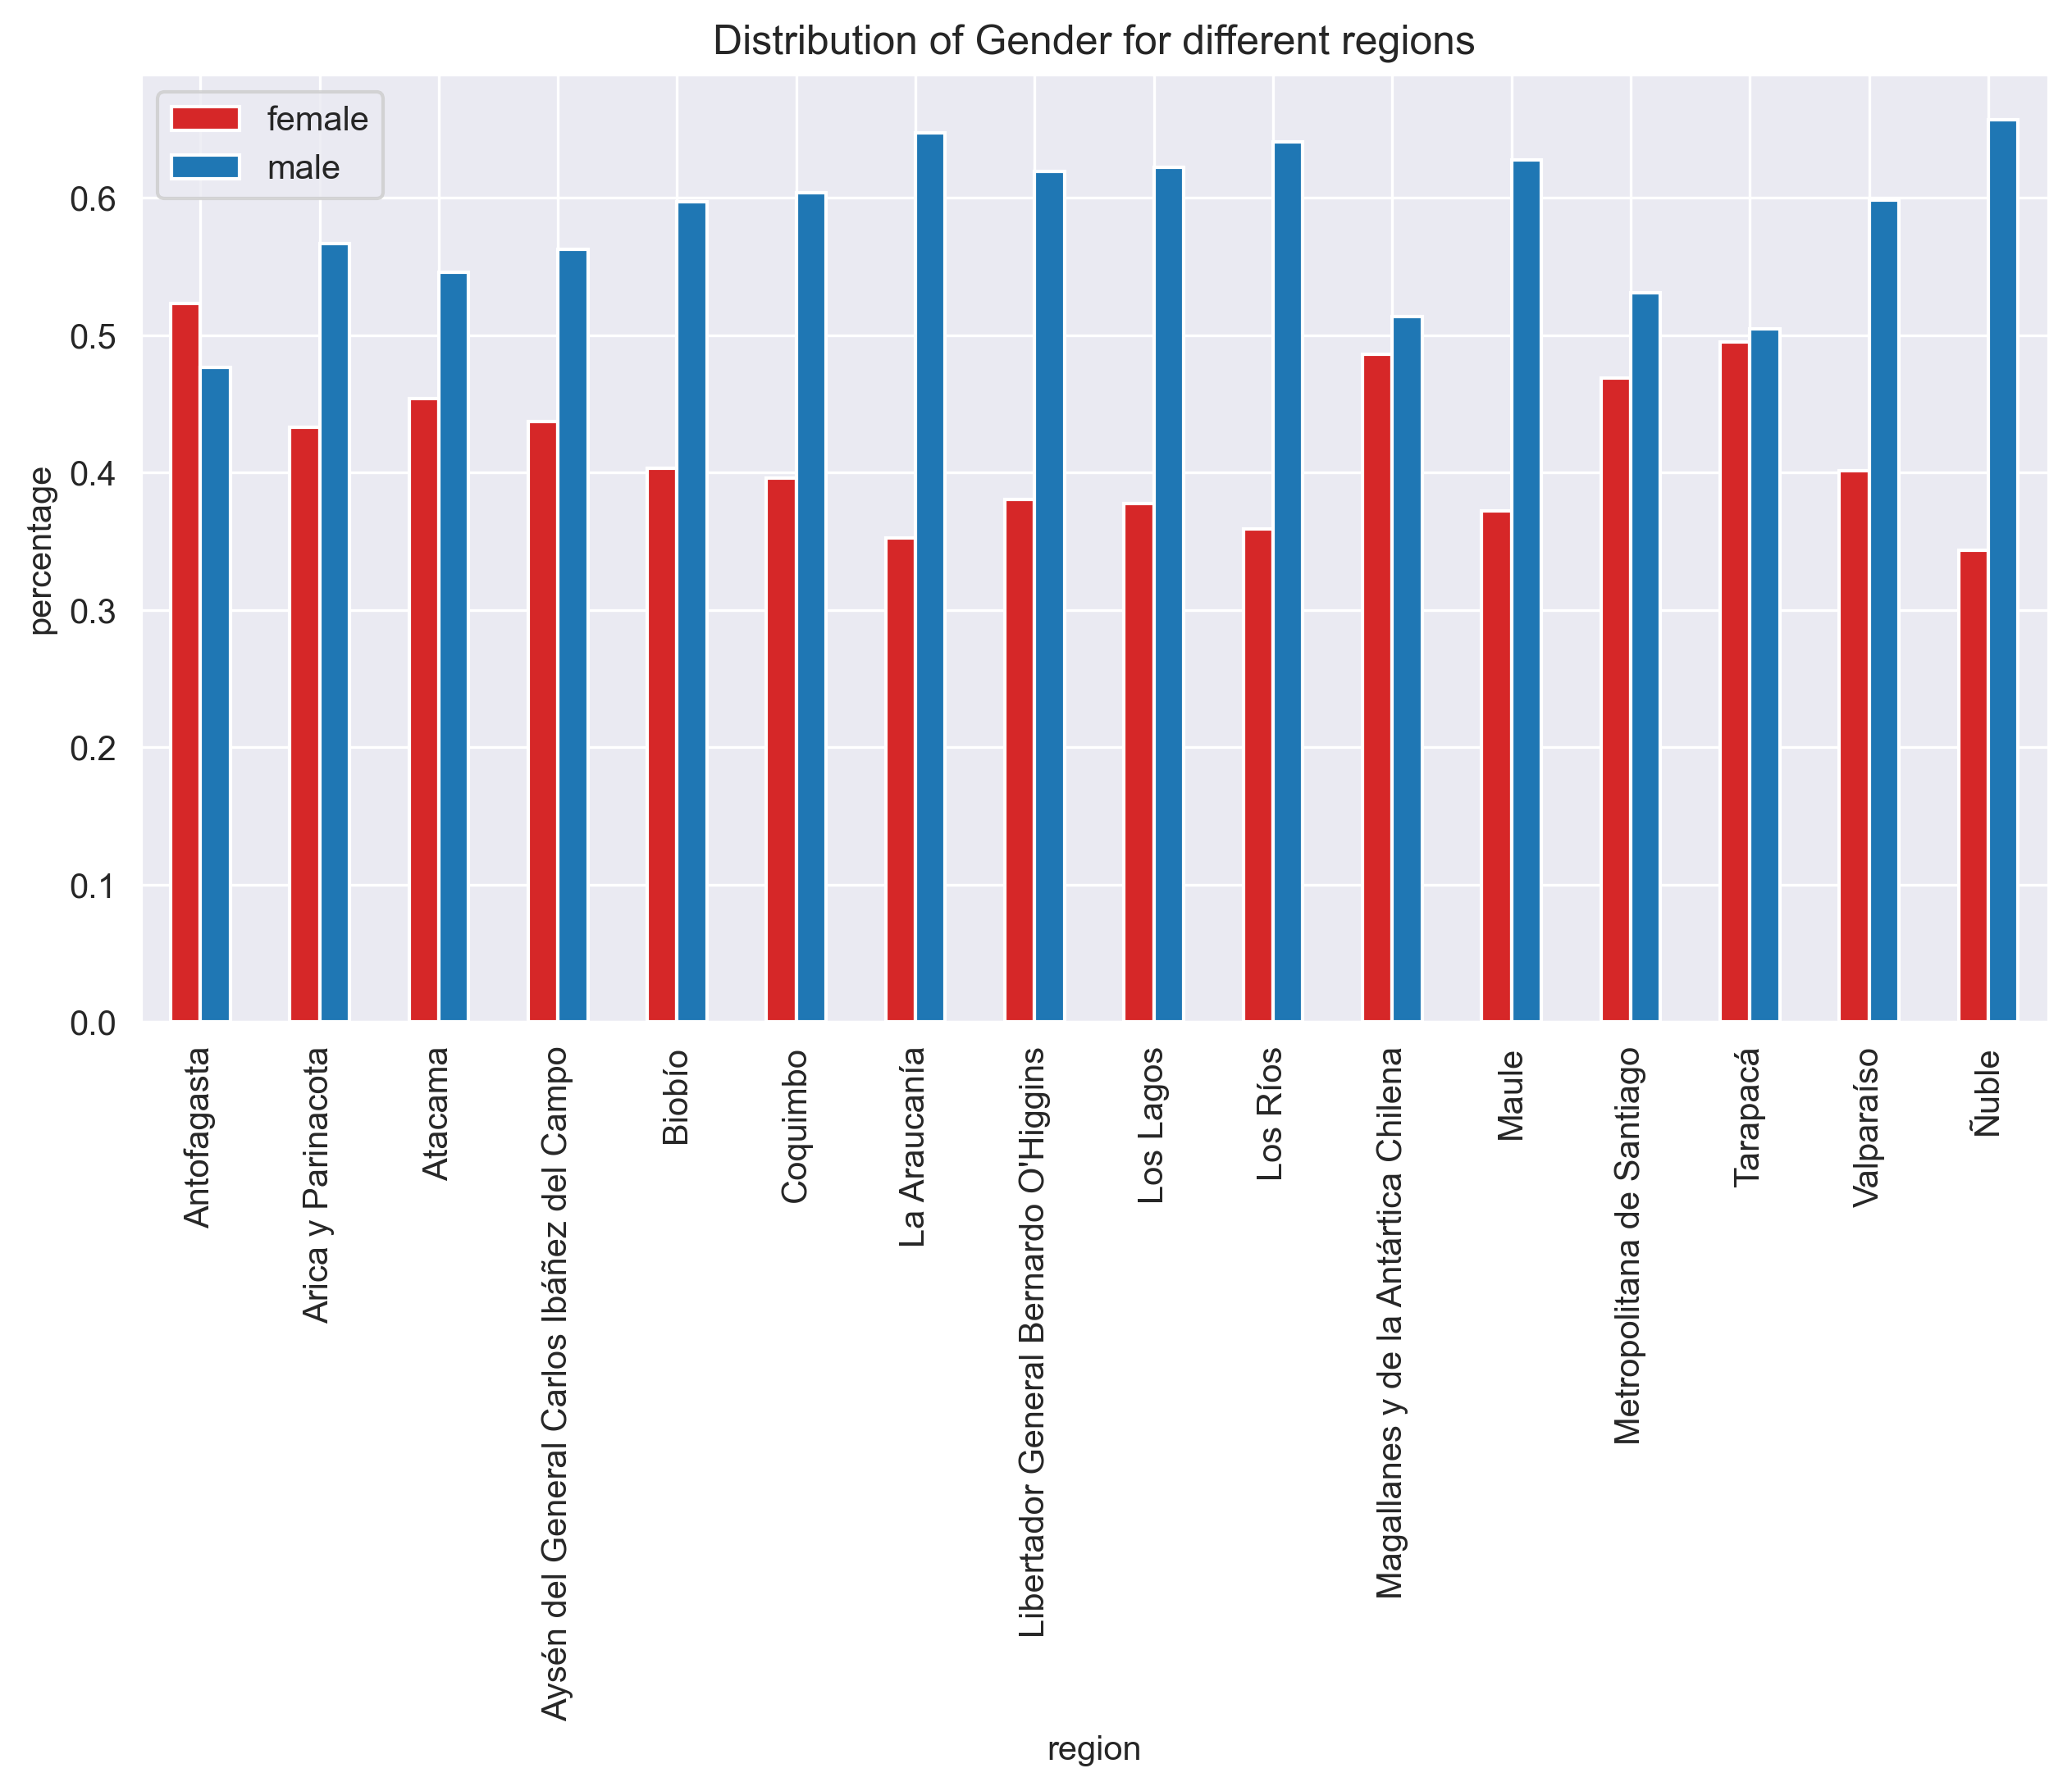

In [494]:
# Create bar plot about gender equality in different regions
region = df[['region', 'sex']].groupby(['region', 'sex']).size()
region_sums = region.to_numpy().reshape(-1, 2).sum(axis=1)

region = region.unstack(1).reset_index()

# in this small case we ignore the pandas antipattern by looping through the data
for i in range(len(region_sums)):
    region.loc[i, 'Female'] = region.loc[i, 'Female'] / region_sums[i]
    region.loc[i, 'Male'] = region.loc[i, 'Male'] / region_sums[i]

region.plot(x='region',
            y=['Female', 'Male'],
            color=['tab:red', 'tab:blue'],
            label=['female', 'male'],
            kind='bar')

plt.title("Distribution of Gender for different regions")
plt.xticks(rotation=90)
plt.ylabel("percentage")
plt.legend(loc='best')

plt.show()

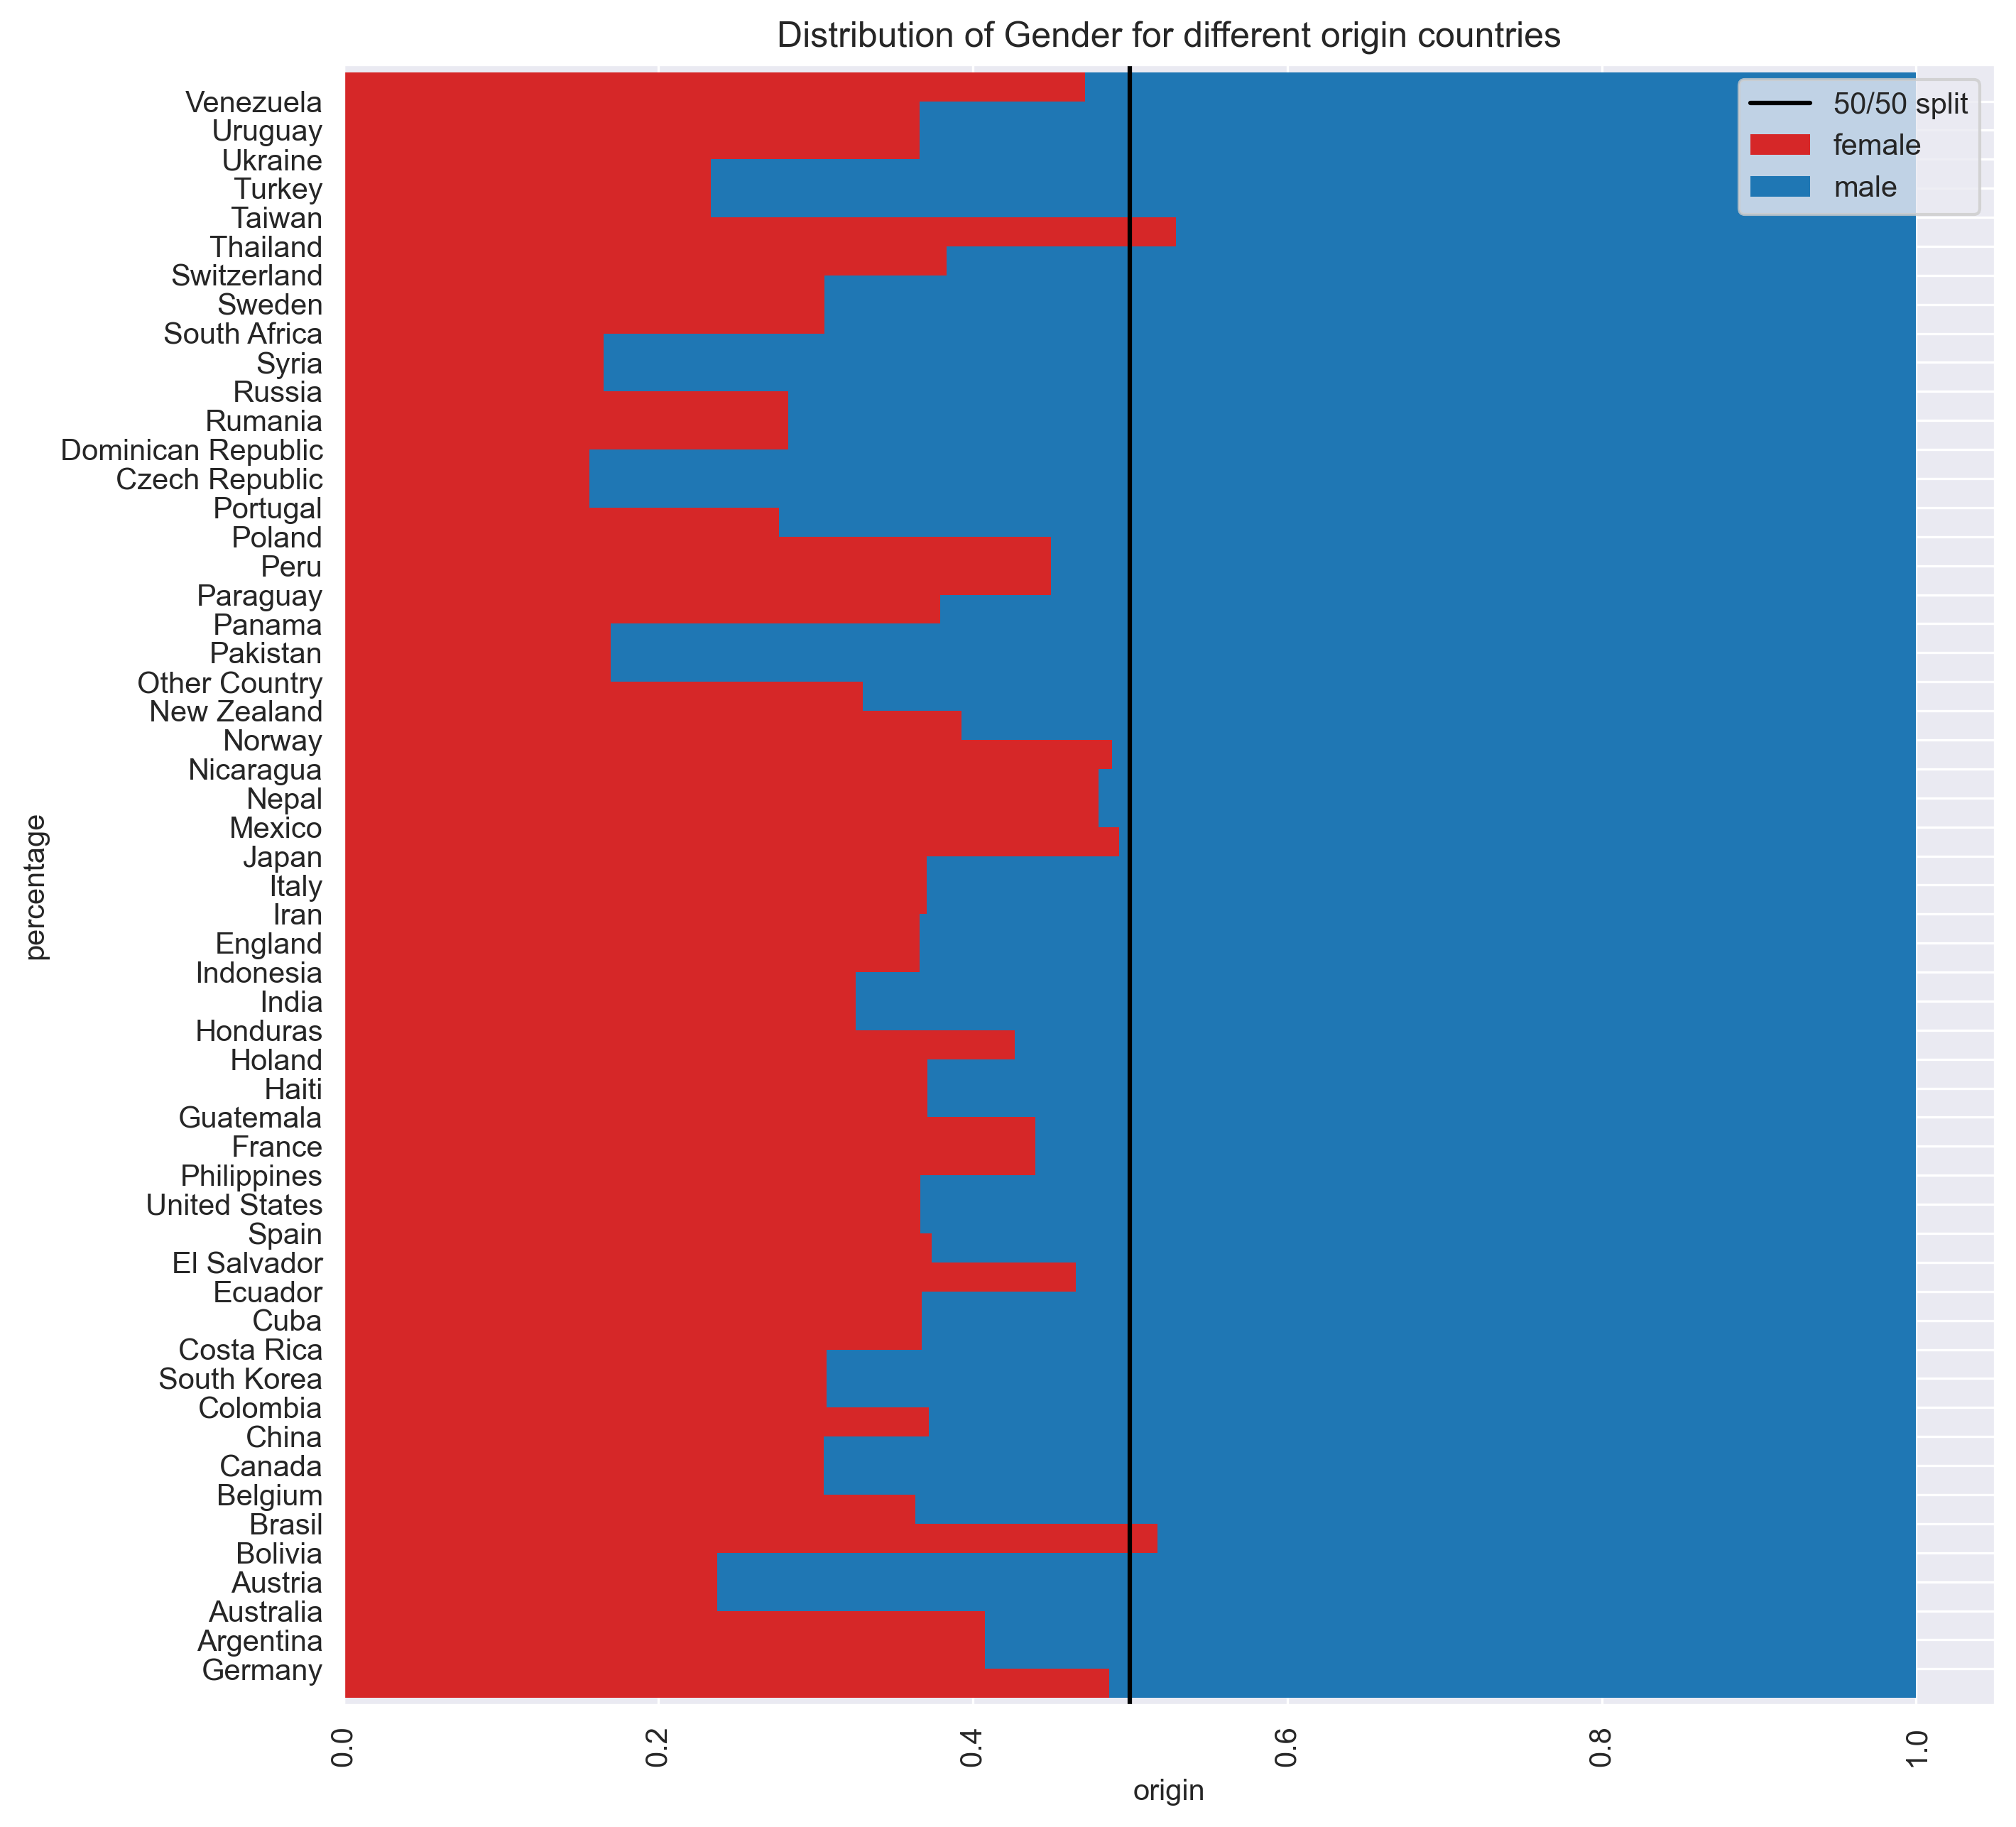

In [614]:
# Create bar plot about gender equality for different countries of origin [at least 25 immigrants]
origin = df[['country', 'sex']]

origin = origin.groupby(['country']).filter(lambda x: x.size // 2 >= 25)
origin['country'] = origin['country'].cat.remove_unused_categories()
origin = origin.groupby(['country', 'sex']).size()
origin_sums = origin.to_numpy().reshape(-1, 2).sum(axis=1)

origin = origin.unstack(1).reset_index()


# in this small case we ignore the pandas antipattern by looping through the data
for i in range(len(origin_sums)):
    origin.loc[i, 'Female'] = origin.loc[i, 'Female'] / origin_sums[i]
    origin.loc[i, 'Male'] = origin.loc[i, 'Male'] / origin_sums[i]

origin.plot(x='country',
            y=['Female', 'Male'],
            color=['tab:red', 'tab:blue'],
            label=['female', 'male'],
            kind='barh',
            width=2,
            align='center',
            linewidth=0,
            stacked=True,
            figsize=(10, 10))

plt.axvline(x=0.5, color='black', label='50/50 split')

plt.title("Distribution of Gender for different origin countries")
plt.xticks(rotation=90)
plt.xlabel("origin")
plt.ylabel("percentage")
plt.legend(loc='best')

plt.show()

These plots show that for almost all countries a lot less women than men come to Chile as immigrants. Only for academic purposes the gender gap is 0 which proofs the thesis that the sex distribution for students is more equal than for the rest of the visa. Also interesting is that people with higher education are more likely to be female than male, contradicting therefore the overall trend.